In [71]:
# Initial setup:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 1

#For fancy plots
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
from matplotlib.patches import Ellipse

import numpy as np
from scipy.special import erfcinv
import scipy.stats as st
from scipy.stats import chi2, multivariate_normal, gamma
from scipy.special import erfcinv, erfinv, erf, erfc
from scipy.linalg import sqrtm, inv

import getdist
from getdist import plots, MCSamples
getdist.chains.print_load_details = False

import git
import sys, os

# Create the two toy chains and the joint chain:
path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
path_global = os.path.dirname(path_git)
print('Path to git repo: {}'.format(path_global))

chi2_val = chi2.ppf(0.6827, df=2)

d = 2
L = 3  # Number of vectors
n_samples = int(1e6)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Path to git repo: /home/matias/Documents/PhD/code


# PTE to $N_{\sigma}$

Que es $N_{\sigma}^{eff}$? Hagamos algunos graficos

In [72]:
import numpy as np
from math import erf, sqrt
from scipy.stats import chi2

def L_iso_from_n(d: int, n: float, sigma2: float = 0.5, gauss_scale: str = '1sigma') -> float:
    """
    Distancia euclídea L entre las medias de dos Gaussianas D-dimensionales
    idénticas e isotrópicas (Sigma = sigma2 * I), tal que sus contornos 
    que en 1D corresponden a ±nσ se 'toquen'.

    Parámetros
    ----------
    d : int
        Dimensión (D).
    n : float
        'Número de sigmas' 1D (es decir, p = erf(n / sqrt(2))).
    sigma2 : float, opcional
        Varianza isotrópica por eje (default 0.5).

    Devuelve
    --------
    L : float
        Distancia euclídea entre medias.
    """


    if gauss_scale == '1sigma':
        # Probabilidad 1D asociada a ±nσ
        p = erf(n / sqrt(2.0)) #is the same, less general
        #p = chi2.cdf(n**2, df=1)  # Cumulative distribution function for chi2Q
    elif gauss_scale == '2sigma':
        p = chi2.cdf(n**2, df=2)  # Cumulative distribution function for chi2

    # Cuantil chi-cuadrado con d grados de libertad
    m2 = chi2.ppf(p, df=d)              # m^2 = χ²_{d,p}
    m  = sqrt(m2)
    # En isotrópico: L = 2 * σ * m, con σ = sqrt(sigma2)
    return 2.0 * sqrt(sigma2) * m

print('--- Using 1sigma scale ---')
for n in [1, 2, 3, 4, 5]:
    print(n, L_iso_from_n(d=2, n=n))   # d=2, sigma^2=0.5

print('--- Using 2sigma scale ---')
for n in [1, 2, 3, 4, 5]:
    print(n, L_iso_from_n(d=2, n=n, gauss_scale='2sigma'))   # d=2, sigma^2=0.5

--- Using 1sigma scale ---
1 2.142778070122352
2 3.515700301858557
3 4.863981513513553
4 6.21834521588094
5 7.5820448992254725
--- Using 2sigma scale ---
1 1.4142135623730951
2 2.8284271247461903
3 4.242640687119287
4 5.656854249492375
5 7.071067811867373


Factor: 2.142778070122352, PTE: 0.0567, N_sigma: 1.91


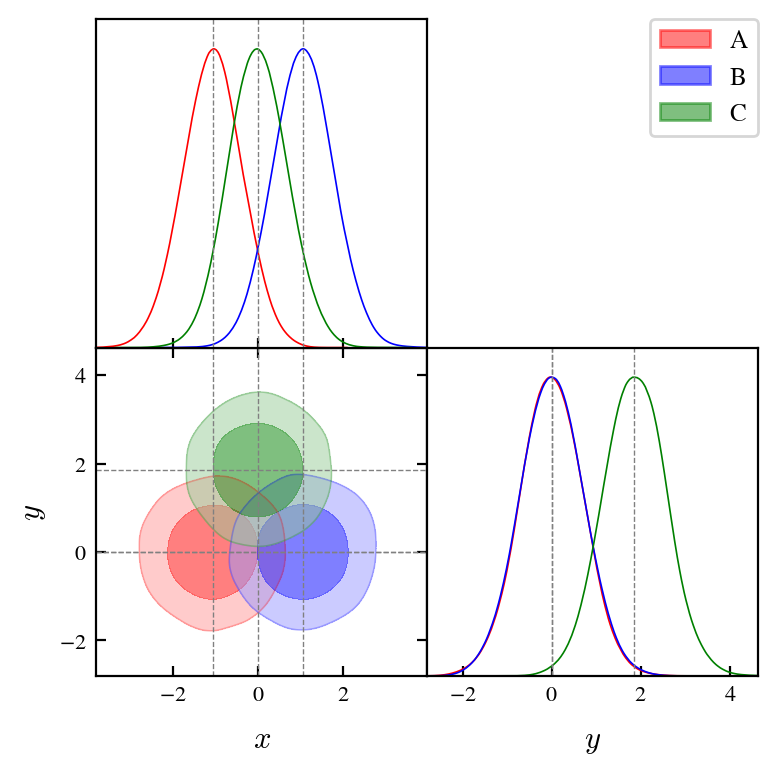

Factor: 3.515700301858557, PTE: 5.73e-05, N_sigma: 4.02


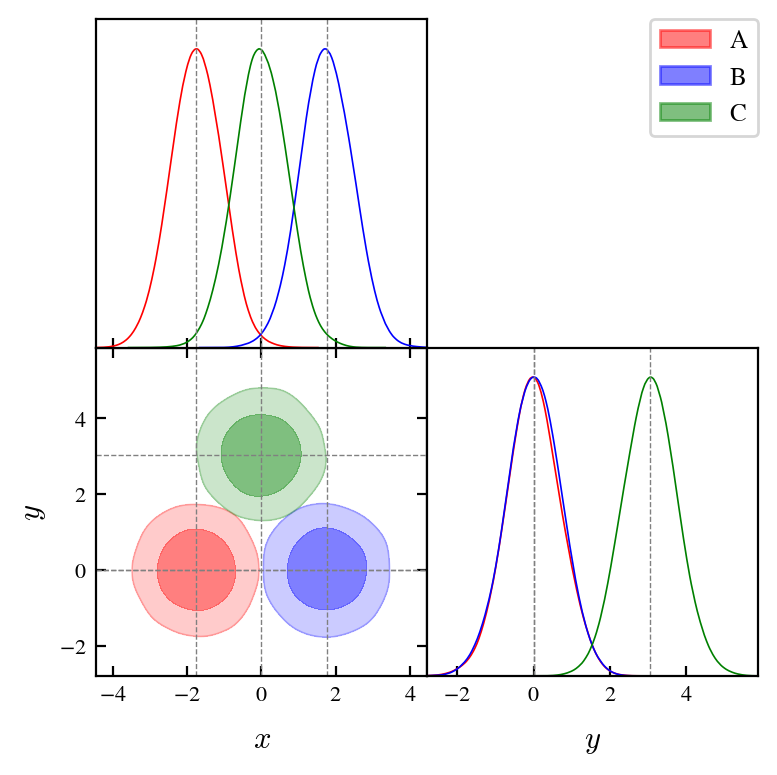

Factor: 4.863981513513553, PTE: 1.31e-09, N_sigma: 6.07


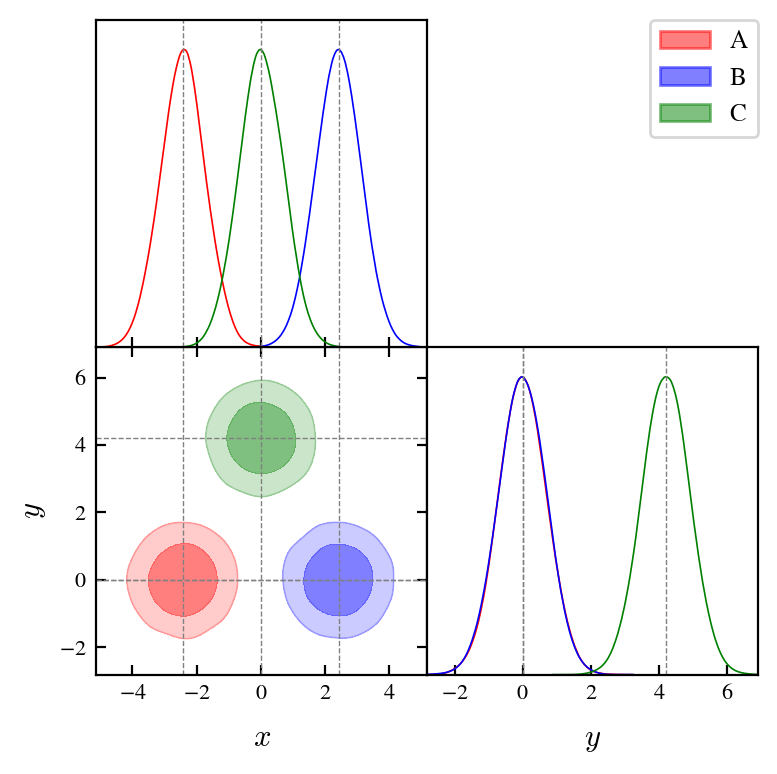

In [73]:
#Sharp triangle
#factor = [0., 2.1, 3.5]
factor = [L_iso_from_n(d=2, n=1), L_iso_from_n(d=2, n=2), L_iso_from_n(d=2, n=3)]


for i in range(len(factor)):
    mean_A = factor[i] * np.array([-1/2., 0.])
    mean_B = factor[i] * np.array([1/2, 0.])
    mean_C = factor[i] * np.array([0, np.sqrt(3)/2.])

    cov_A = np.eye(d) / 2
    cov_B = cov_A.copy()
    cov_C = cov_A.copy()

    r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
    r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
    r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))

    # Example usage:
    beta_L = (np.linalg.norm(r_1)**2 + np.linalg.norm(r_2)**2 + np.linalg.norm(r_3)**2)/L

    PTE = gamma(a=d, scale=1).sf(beta_L)
    n_sigma = np.sqrt(2)*erfcinv(PTE)

    print(f"Factor: {factor[i]}, PTE: {PTE:.3g}, N_sigma: {n_sigma:.3g}")


    names = ['x', 'y']
    labels = ['x', 'y']

    lim_x = np.array([-10, 10])
    lim_y = np.array([-10, 10])

    samps_A = np.random.multivariate_normal(mean_A, cov_A, size=10000)
    samps_B = np.random.multivariate_normal(mean_B, cov_B, size=10000)
    samps_C = np.random.multivariate_normal(mean_C, cov_C, size=10000)

    chain_A = MCSamples(samples=samps_A, names=names, labels=labels, label='Dataset A')
    chain_B = MCSamples(samples=samps_B, names=names, labels=labels, label='Dataset B')
    chain_C = MCSamples(samples=samps_C, names=names, labels=labels, label='Dataset C')

    colors = ['red', 'blue', 'green']

    g = plots.get_subplot_plotter()
    g.triangle_plot([chain_A, chain_B, chain_C],\
                    filled=True, contour_args={'alpha':0.5},\
                    contour_colors=colors,
                    legend_labels=['A', 'B', 'C'])
    g.add_param_markers({'x':[mean_A[0], mean_B[0], mean_C[0]],
                        'y':[mean_A[1], mean_B[1], mean_C[1]],
                        },)

    g.export(os.path.join(path_global, 'multidimensional_qdm_tension_vectors_triangle_L_{:.3g}.pdf'.format(factor[i])))
    g.export(os.path.join(path_global, 'multidimensional_qdm_tension_vectors_triangle_L_{:.3g}.svg'.format(factor[i])))
    plt.show()

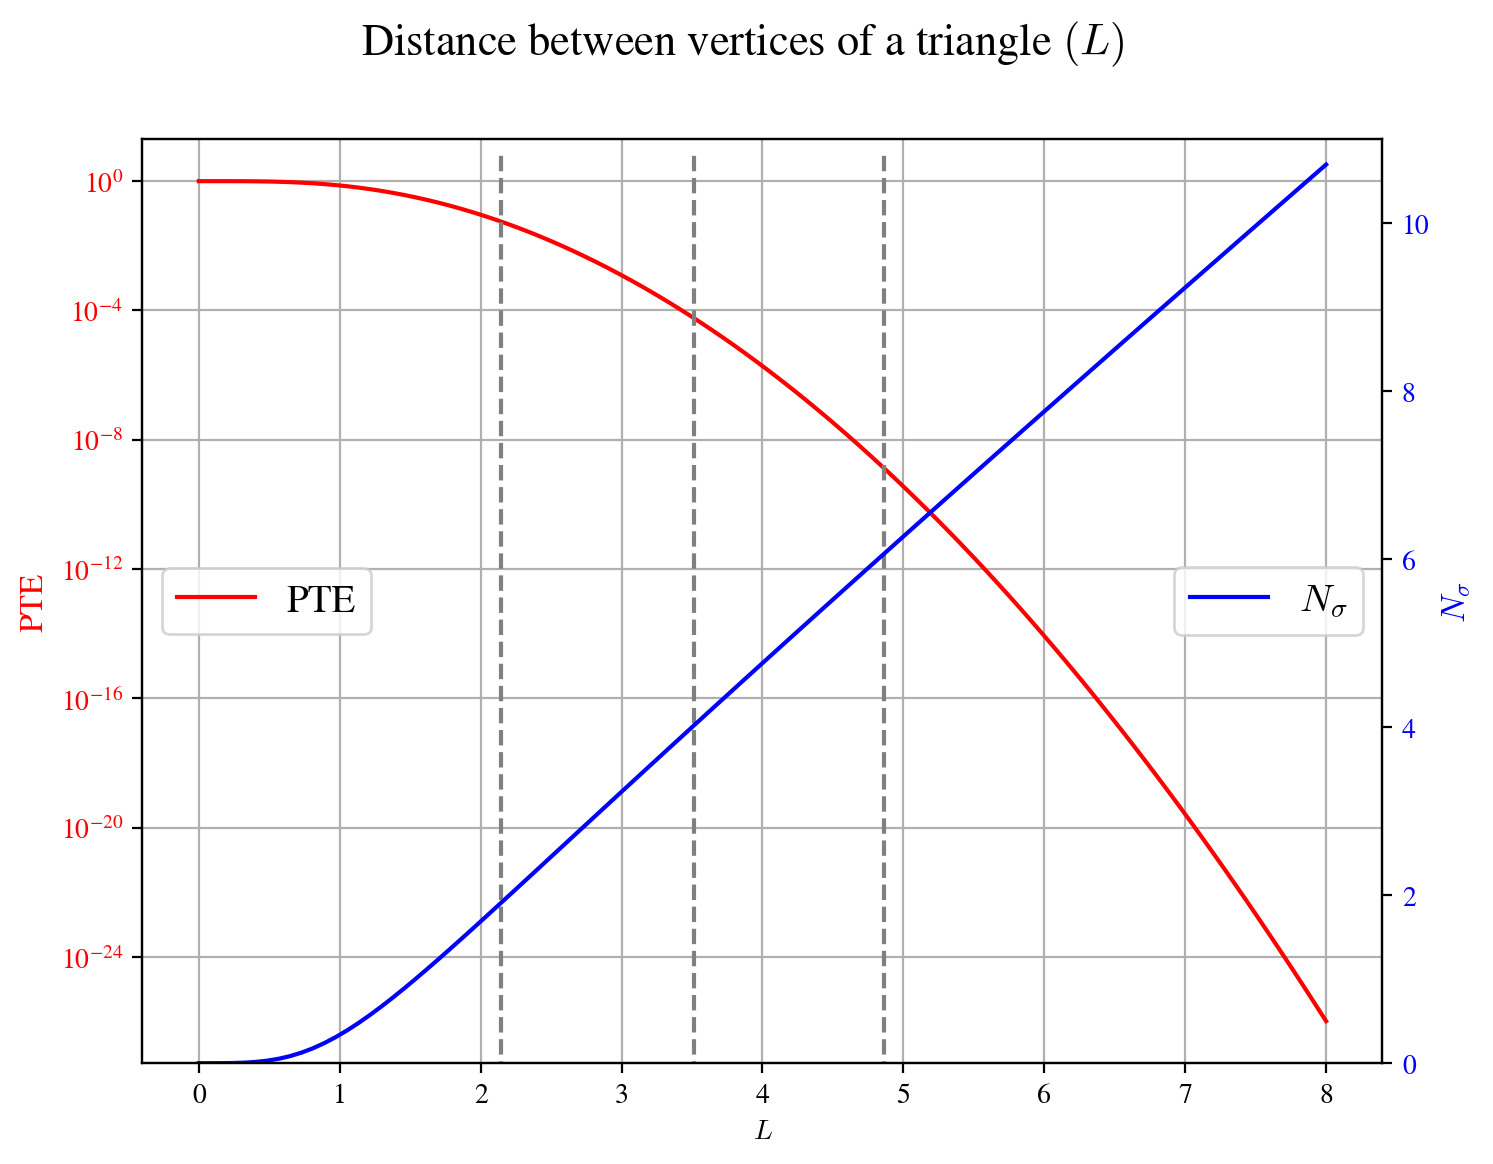

In [74]:
#Sharp triangle
factor_line = [L_iso_from_n(d=2, n=1), L_iso_from_n(d=2, n=2), L_iso_from_n(d=2, n=3)]

factor = np.linspace(0, 8, 100)
PTE_arr = np.zeros(len(factor))
n_sigma_arr = np.zeros(len(factor))

for i in range(len(factor)):
    mean_A = factor[i] * np.array([-1/2., 0.]) 
    mean_B = factor[i] * np.array([1/2, 0.])
    mean_C = factor[i] * np.array([0, np.sqrt(3)/2.])

    cov_A = np.eye(d) / 2
    cov_B = cov_A.copy()
    cov_C = cov_A.copy()

    r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
    r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
    r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))

    # Example usage:
    beta_L = (np.linalg.norm(r_1)**2 + np.linalg.norm(r_2)**2 + np.linalg.norm(r_3)**2)/L

    PTE_arr[i] = gamma(a=d, scale=1).sf(beta_L)
    n_sigma_arr[i] = np.sqrt(2)*erfcinv(PTE_arr[i])

fig, axes = plt.subplots(1,1, figsize=(8, 6))
fig.suptitle(r'Distance between vertices of a triangle $(L)$'.format(factor[i]), fontsize=16)

ax1 = axes
ax2 = ax1.twinx()

#ax1.set_ylim(0, 1)
ax2.set_ylim(0, 11)


ax1.plot(factor, PTE_arr, label='PTE', color='red')
ax1.set_yscale('log')
ax1.set_xlabel(r'$L$')
ax1.set_ylabel('PTE', color='red', fontsize=12)
ax1.tick_params(axis='y', labelcolor='red')
for i in range(len(factor_line)):
    ax1.vlines(x=factor_line[i], ymin=0, ymax=8, color='gray', linestyle='--')

ax2.plot(factor, n_sigma_arr, label='$N_\sigma$', color='blue')
ax2.set_ylabel('$N_\sigma$', color='blue', fontsize=12)
ax2.tick_params(axis='y', labelcolor='blue')

ax1.legend(loc='center left', fontsize=14)
ax2.legend(loc='center right', fontsize=14)

ax1.grid()

fig.savefig(os.path.join(path_global, 'multidimensional_qdm_tension_vectors_sweap_cov.png'), dpi=300, bbox_inches='tight')
fig.savefig(os.path.join(path_global, 'multidimensional_qdm_tension_vectors_sweap_cov.pdf'), dpi=300, bbox_inches='tight')
fig.savefig(os.path.join(path_global, 'multidimensional_qdm_tension_vectors_sweap_cov.svg'), dpi=300, bbox_inches='tight')
plt.show()

# $N_\sigma^{eff}(N_\sigma)$ and $L(N_\sigma)$

In [75]:
from scipy.interpolate import interp1d

# Create the interpolation functi<on for factor and n_sigma_arr
factor_from_n_sigma = interp1d(n_sigma_arr, factor, bounds_error=False, fill_value="extrapolate")

# Example usage
n_sigma_test = 4.7
n_sigma_test_factor = factor_from_n_sigma(n_sigma_test)
print(f"For N_sigma = {n_sigma_test :.3g}, factor = {n_sigma_test_factor :.3g}")

# Generate data points for interpolation
N_sigma_eff_values = np.linspace(0.1, 5, 100)
L_values = [L_iso_from_n(d=2, n=n, gauss_scale='1sigma') for n in N_sigma_eff_values]

# Create the interpolation function
N_sigma_from_L = interp1d(L_values, N_sigma_eff_values, bounds_error=False, fill_value="extrapolate")

# Example usage
L_test = n_sigma_test_factor
N_sigma_test = N_sigma_from_L(L_test)
print(f"For L = {L_test :.3g}, N_sigma = {N_sigma_test :.3g}")


For N_sigma = 4.7, factor = 3.96
For L = 3.96, N_sigma = 2.33


# Three moltivariate distributions

In [76]:
#Sharp triangle
mean_A = np.array([-1/2., 0.]) 
mean_B = np.array([1/2, 0.])
mean_C = np.array([0, np.sqrt(3)/2.])

cov_A = np.array([[1, 0.], [0., 1]])
cov_B = cov_A.copy()
cov_C = cov_A.copy()

In [77]:
#Define some functions:

def calculate_R_CM(vectors):
    num_vectors = len(vectors)
    R_CM = np.sum(vectors, axis=0) / num_vectors
    return R_CM


def construct_C(vectors):
    L = len(vectors)

    K_xx = np.sum((vectors[:, 0]) ** 2)
    K_yy = np.sum((vectors[:, 1]) ** 2)
    K_xy = np.sum((vectors[:, 0]) * (vectors[:, 1]))
    K_yx = K_xy
    C = np.array([[K_xx, K_xy], [K_yx,K_yy]])/L
    return C

def analyzed_lambdas(vectors):
    L = len(vectors)
    C = construct_C(vectors)
    lambdas = np.linalg.eigvals(C)
    mean_lambda = np.sum(lambdas)/L
    std_lambda = np.std(lambdas)
    return mean_lambda, std_lambda

def PTE_2_l(PTE):
    aux = gamma(d,1).isf(PTE) #(beta/L)*
    #l = 2*aux
    l = np.sqrt(aux)
    return l


def L_iso_from_n_eff(d: int, n: float, sigma2: float = 0.5, gauss_scale: str = '1sigma') -> float:
    """
    Distancia euclídea L entre las medias de dos Gaussianas D-dimensionales
    idénticas e isotrópicas (Sigma = sigma2 * I), tal que sus contornos 
    que en 1D corresponden a ±nσ se 'toquen'.

    Parámetros
    ----------
    d : int
        Dimensión (D).
    n : float
        'Número de sigmas' 1D (es decir, p = erf(n / sqrt(2))).
    sigma2 : float, opcional
        Varianza isotrópica por eje (default 0.5).

    Devuelve
    --------
    L : float
        Distancia euclídea entre medias.
    """


    if gauss_scale == '1sigma':
        # Probabilidad 1D asociada a ±nσ
        p = erf(n / sqrt(2.0)) #is the same, less general
        #p = chi2.cdf(n**2, df=1)  # Cumulative distribution function for chi2Q
    elif gauss_scale == '2sigma':
        p = chi2.cdf(n**2, df=2)  # Cumulative distribution function for chi2

    # Cuantil chi-cuadrado con d grados de libertad
    m2 = chi2.ppf(p, df=d)              # m^2 = χ²_{d,p}
    m  = sqrt(m2)
    # En isotrópico: L = 2 * σ * m, con σ = sqrt(sigma2)
    return 2.0 * sqrt(sigma2) * m

def L_to_N_sigma_eff(L, d: int): 
    n_sigma_eff_arr = np.linspace(0, 6, 100)
    L_arr = np.zeros(len(n_sigma_eff_arr))
    for i in range(len(n_sigma_eff_arr)):
        L_arr[i] = L_iso_from_n_eff(d=d, n=n_sigma_eff_arr[i])
    L_to_N_sigma_eff = interp1d(L_arr, n_sigma_eff_arr)(L)
    return L_to_N_sigma_eff

def plot_eff_model(PTE,name_plot, png=False):
    if PTE == 0:
        print("PTE is zero, cannot plot effective model.")
        return
    else:
        l = PTE_2_l(PTE)
        print("Effective model parameter l: {:.3g}".format(l))
        print("Effective model parameter N_sigma_eff: {:.3g}".format(L_to_N_sigma_eff(l, d=2)))
        mean_A = l * np.array([-1/2., 0.]) 
        mean_B = l * np.array([1/2, 0.])
        mean_C = l * np.array([0, np.sqrt(3)/2.])

        cov_A = np.eye(d)/2
        cov_B = cov_A.copy()
        cov_C = cov_A.copy()

        names = ['x', 'y']
        labels = names

        samps_A = np.random.multivariate_normal(mean_A, cov_A, size=10000)
        samps_B = np.random.multivariate_normal(mean_B, cov_B, size=10000)
        samps_C = np.random.multivariate_normal(mean_C, cov_C, size=10000)

        chain_A = MCSamples(samples=samps_A, names=names, labels=labels, label='Dataset A')
        chain_B = MCSamples(samples=samps_B, names=names, labels=labels, label='Dataset B')
        chain_C = MCSamples(samples=samps_C, names=names, labels=labels, label='Dataset C')

        colors = ['red', 'blue', 'green']

        g = plots.get_subplot_plotter()
        g.triangle_plot([chain_A, chain_B, chain_C],\
                        filled=True, contour_args={'alpha':0.5},\
                        contour_colors=colors,
                        legend_labels=['A', 'B', 'C'])
        
        g.add_param_markers({'x':[mean_A[0], mean_B[0], mean_C[0]],
                             'y':[mean_A[1], mean_B[1], mean_C[1]],
                            },)

        #os.chdir(os.path.join(path_git, 'notebooks','PRL', 'tests', 'figures'))
        if png==True:
            g.export(os.path.join(path_global, 'dist_eff_{}.png'.format(name_plot)))
        else:
            g.export(os.path.join(path_global, 'dist_eff_{}.pdf'.format(name_plot)))
            g.export(os.path.join(path_global, 'dist_eff_{}.svg'.format(name_plot)))
        plt.show()


In [78]:
def Q_tot_quad(mean_A, mean_B, mean_C, cov_A, cov_B, cov_C, n_samples, L, H0=False):
    cov_1 = cov_A + cov_B
    cov_2 = cov_A + cov_C
    cov_3 = cov_B + cov_C

    DA = np.random.multivariate_normal(mean_A, cov_A, size=n_samples)
    DB = np.random.multivariate_normal(mean_B, cov_B, size=n_samples)
    DC = np.random.multivariate_normal(mean_C, cov_C, size=n_samples)
    
    # Sampling
    sample_1 = np.dot(sqrtm(np.linalg.inv(cov_1)), np.array(DA-DB).T)  # Shape: (d, n_samples)
    sample_2 = np.dot(sqrtm(np.linalg.inv(cov_2)), np.array(DA-DC).T)  # Shape: (d, n_samples)
    sample_3 = np.dot(sqrtm(np.linalg.inv(cov_3)), np.array(DB-DC).T)  # Shape: (d, n_samples)
    
    if H0==True:
        sample_1_H0 = sample_1 - np.mean(sample_1, axis=1, keepdims=True)
        sample_2_H0 = sample_2 - np.mean(sample_2, axis=1, keepdims=True)
        sample_3_H0 = sample_3 - np.mean(sample_3, axis=1, keepdims=True)
        
        Q = np.zeros(n_samples)
        for i in range(n_samples):
            Q[i] = np.linalg.norm(sample_1_H0[:,i])**2 + np.linalg.norm(sample_2_H0[:,i])**2 + np.linalg.norm(sample_3_H0[:,i])**2       
    else:
        Q = np.zeros(n_samples)
        for i in range(n_samples):
            Q[i] = np.linalg.norm(sample_1[:,i])**2 + np.linalg.norm(sample_2[:,i])**2 + np.linalg.norm(sample_3[:,i])**2

    return Q / L

In [79]:
def plot_geom(mean_A, mean_B, mean_C, cov_A, cov_B, cov_C, title, name_plot, png=False, eff_dist = False,
              analytic_tension = False):

    names = ['x', 'y']
    labels = ['x', 'y']

    r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
    r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
    r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))
    r_4 = - r_1
    r_5 = - r_2
    r_6 = - r_3

    # Example usage:
    C_tot = construct_C(np.array([r_1, r_2, r_3, r_4, r_5, r_6]))

    beta_L = (np.linalg.norm(r_1)**2 + np.linalg.norm(r_2)**2 + np.linalg.norm(r_3)**2)/3
    if analytic_tension == False:
        Q_H0 =Q_tot_quad(mean_A, mean_B, mean_C, cov_A, cov_B, cov_C, n_samples, 3, H0=True)
        PTE = Q_H0[Q_H0 > beta_L].size/Q_H0.size
        
    elif analytic_tension == True:
        PTE = gamma(d,1).sf(beta_L)

    n_sigma = np.sqrt(2)*erfcinv(PTE)


    lim_x = np.array([-10, 10])
    lim_y = np.array([-10, 10])

    samps_A = np.random.multivariate_normal(mean_A, cov_A, size=10000)
    samps_B = np.random.multivariate_normal(mean_B, cov_B, size=10000)
    samps_C = np.random.multivariate_normal(mean_C, cov_C, size=10000)

    chain_A = MCSamples(samples=samps_A, names=names, labels=labels, label='Dataset A')
    chain_B = MCSamples(samples=samps_B, names=names, labels=labels, label='Dataset B')
    chain_C = MCSamples(samples=samps_C, names=names, labels=labels, label='Dataset C')

    colors = ['red', 'blue', 'green']

    g = plots.get_subplot_plotter()
    g.triangle_plot([chain_A, chain_B, chain_C],\
                    filled=True, contour_args={'alpha':0.5},\
                    contour_colors=colors,
                    legend_labels=['A', 'B', 'C'])

    g.add_param_markers({'x':[mean_A[0], mean_B[0], mean_C[0]],
                         'y':[mean_A[1], mean_B[1], mean_C[1]],
                        },)
    
    if png==True:
        g.export('dist_{}.png'.format(name_plot))
    else:
        g.export('dist_{}.pdf'.format(name_plot))
        g.export('dist_eff_{}.svg'.format(name_plot))

    #fig, ax = plt.subplots(1,1, figsize=(14,10))
    fig, ax = plt.subplots(1,1, figsize=(7,7))
    fig.suptitle(title, fontsize=16)


    ax.set_xlabel(r'$\Delta x$',size=14)
    ax.set_ylabel(r'$\Delta y$',size=14)
    #ax.hlines(0, lim_x[0], lim_x[1], color='black', lw=0.5)
    #ax.vlines(0, lim_y[0], lim_y[1], color='black', lw=0.5)

    ax.quiver(0, 0, r_1[0], r_1[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)
    ax.quiver(0, 0, r_2[0], r_2[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)
    ax.quiver(0, 0, r_3[0], r_3[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)
    ax.quiver(0, 0, r_4[0], r_4[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)
    ax.quiver(0, 0, r_5[0], r_5[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)
    ax.quiver(0, 0, r_6[0], r_6[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,alpha=0.5)

    ax.scatter([r_1[0], r_2[0], r_3[0]], [r_1[1], r_2[1], r_3[1]], marker='.',color='green', label=r'$\vec{r}_{k}$')
    ax.scatter([0], [0], color='black')#, label='CM')

    ax.quiver(0, 0, np.linalg.eig(C_tot)[1][0, 0], np.linalg.eig(C_tot)[1][1, 0], angles='xy', scale_units='xy', scale=1, color='r', width=0.005,label=r'Eigenvector 1, $\lambda_1={:.1f}$'.format(np.linalg.eig(C_tot)[0][0]))
    ax.quiver(0, 0, np.linalg.eig(C_tot)[1][0, 1], np.linalg.eig(C_tot)[1][1, 1], angles='xy', scale_units='xy', scale=1, color='b', width=0.005,label=r'Eigenvector 2, $\lambda_2={:.1f}$'.format(np.linalg.eig(C_tot)[0][1]))

    ax.text(r_1[0]-0.5, r_1[1]+0.5, 'AB', size=10)
    ax.text(r_2[0]-0.5, r_2[1]-0.5, 'AC', size=10)
    ax.text(r_3[0]-0.0, r_3[1]-0.5, 'BC', size=10)
    ax.text(r_4[0]-0.5, r_4[1]+0.5, 'BA', size=10)
    ax.text(r_5[0]-0.5, r_5[1]-0.5, 'CA', size=10)
    ax.text(r_6[0]-0.0, r_6[1]-0.5, 'CB', size=10)

    ax.set_xlim(*lim_x)
    ax.set_ylim(*lim_y)

    ax.legend()
    ax.grid()

    # Para mostrar ambas leyendas en la parte inferior, puedes usar handles y labels manualmente:
    handles1, labels1 = ax.get_legend_handles_labels()
    legend1 = ax.legend(handles=handles1, labels=labels1, loc='lower left', fontsize=12)
    ax.add_artist(legend1)

    legend2 = ax.legend(
        [f'Det = {np.prod(np.linalg.eigvals(C_tot)):.3g}', 
        f'Tr = {np.sum(np.linalg.eigvals(C_tot)):.3g}',
        f'Ecc = {np.sqrt(1-np.min(np.linalg.eigvals(C_tot)) / np.max(np.linalg.eigvals(C_tot))):.3g}',
        f'N_\sigma = {n_sigma:.3g}'],
        loc='lower right', fontsize=9, title='Properties'
    )


    #os.chdir(os.path.join(path_git, 'notebooks','PRL', 'tests', 'figures'))
    if png==True:
        fig.savefig(os.path.join(path_global, 'geom_{}_beta.png'.format(name_plot)), dpi=300, bbox_inches='tight')
    else:
        fig.savefig(os.path.join(path_global, 'geom_{}_beta.pdf'.format(name_plot)), dpi=300, bbox_inches='tight')
        fig.savefig(os.path.join(path_global, 'geom_{}_beta.svg'.format(name_plot)), dpi=300, bbox_inches='tight')
    plt.show()

    if eff_dist == True:
        print(PTE)
        plot_eff_model(PTE, name_plot=name_plot, png=True)

# Case Susana 2

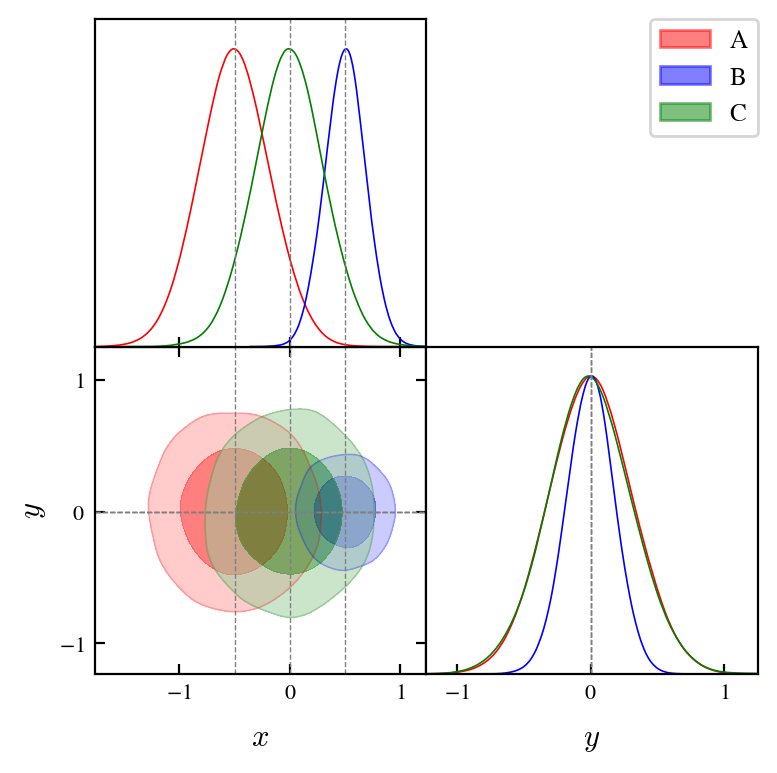

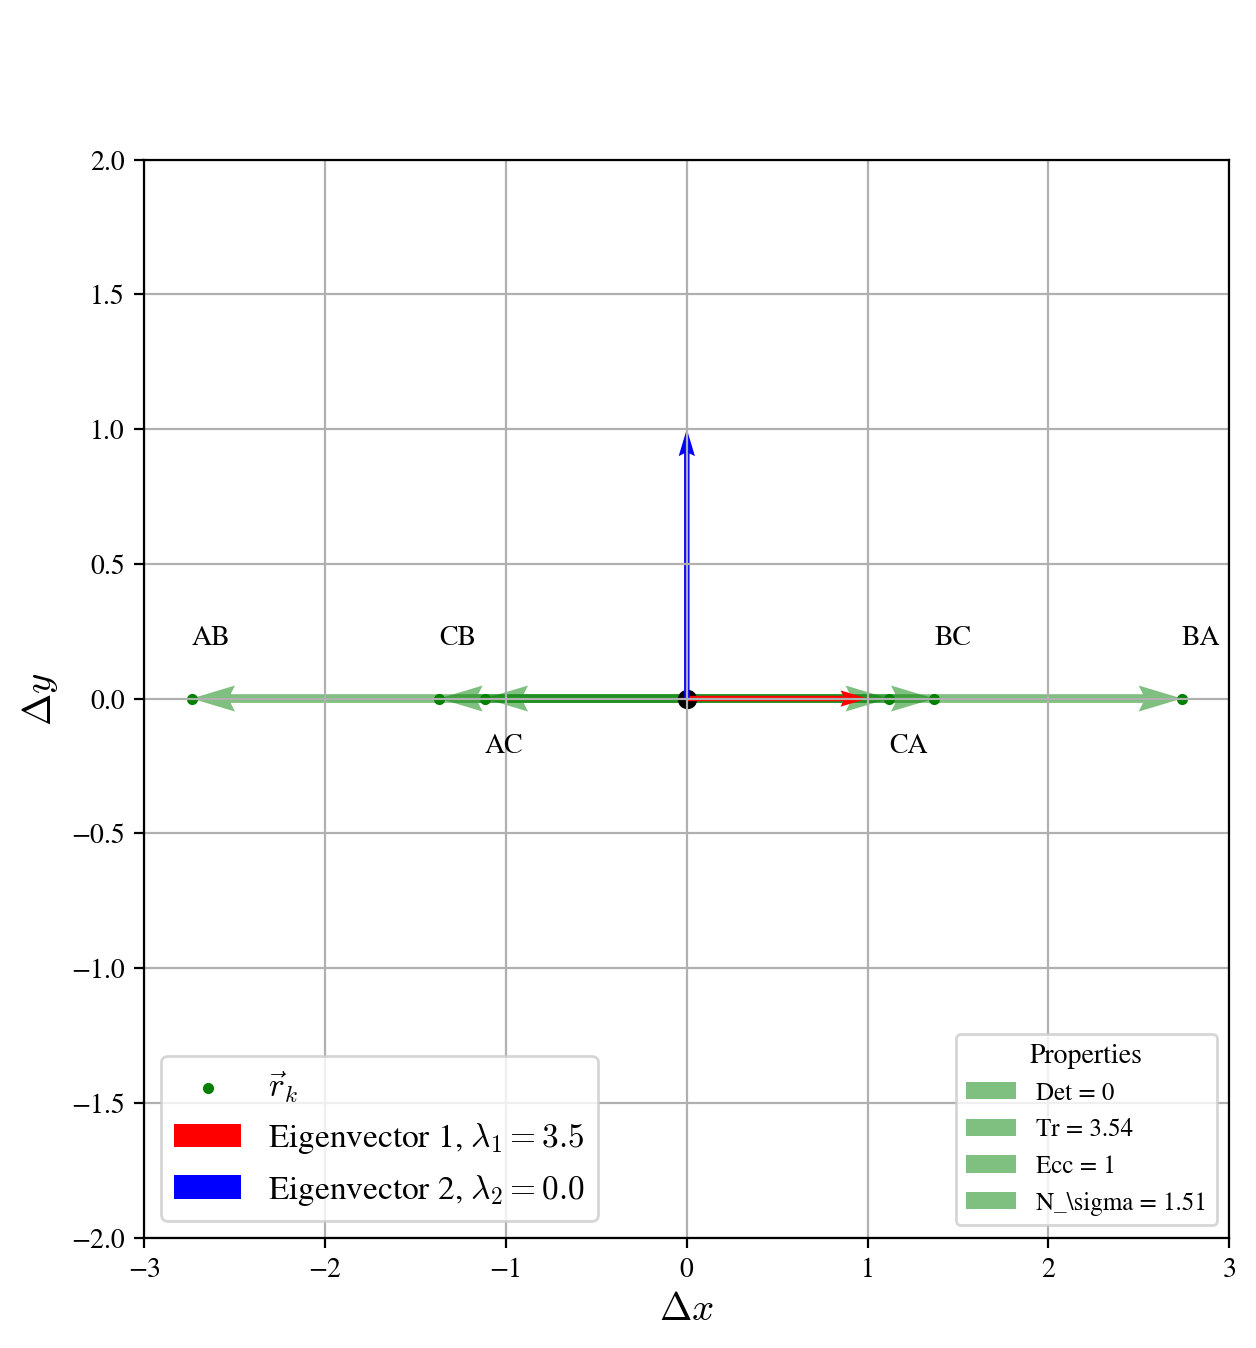

0.131889
Effective model parameter l: 2.13
Effective model parameter N_sigma_eff: 0.991


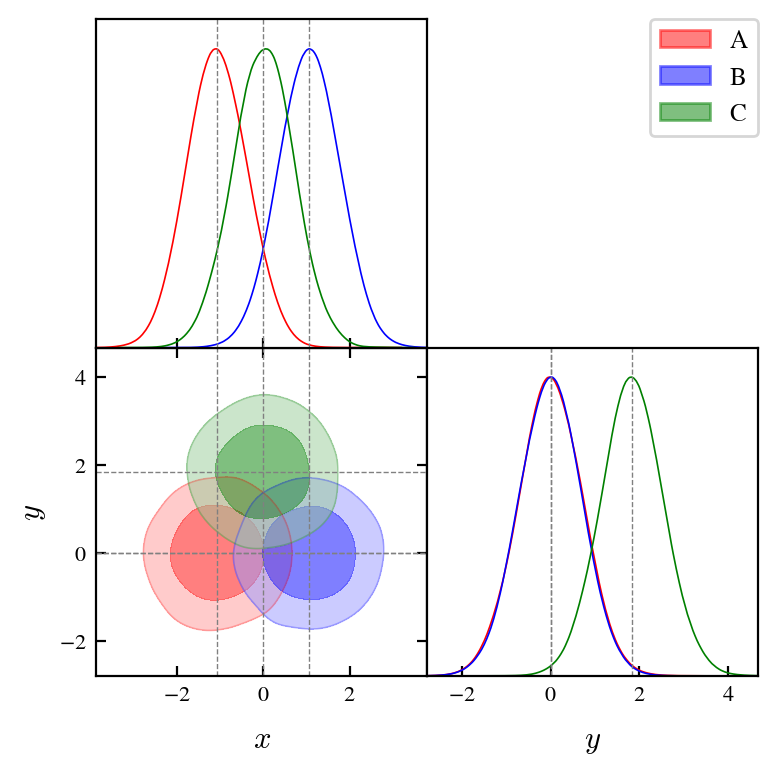

In [80]:
mean_A = np.array([-1/2., 0.]) 
mean_B = np.array([1/2, 0.])
mean_C = np.array([0, 0.])

cov_A = 0.1 * np.eye(d)
cov_B = cov_A.copy()/3
cov_C = cov_A.copy()

r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))
r_4 = - r_1
r_5 = - r_2
r_6 = - r_3



title='Case 2 Susana' 
title=' ' 
name_plot='susana_2'
analytic_tension=False 
eff_dist=True
png=False


names = ['x', 'y']
labels = ['x', 'y']

r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))
r_4 = - r_1
r_5 = - r_2
r_6 = - r_3

# Example usage:
C_tot = construct_C(np.array([r_1, r_2, r_3, r_4, r_5, r_6]))

beta_L = (np.linalg.norm(r_1)**2 + np.linalg.norm(r_2)**2 + np.linalg.norm(r_3)**2)/3
if analytic_tension == False:
    Q_H0 =Q_tot_quad(mean_A, mean_B, mean_C, cov_A, cov_B, cov_C, n_samples, 3, H0=True)
    PTE = Q_H0[Q_H0 > beta_L].size/Q_H0.size
    
elif analytic_tension == True:
    PTE = gamma(d,1).sf(beta_L)

n_sigma = np.sqrt(2)*erfcinv(PTE)


lim_x = np.array([-3, 3])
lim_y = np.array([-2, 2])

samps_A = np.random.multivariate_normal(mean_A, cov_A, size=10000)
samps_B = np.random.multivariate_normal(mean_B, cov_B, size=10000)
samps_C = np.random.multivariate_normal(mean_C, cov_C, size=10000)

chain_A = MCSamples(samples=samps_A, names=names, labels=labels, label='Dataset A')
chain_B = MCSamples(samples=samps_B, names=names, labels=labels, label='Dataset B')
chain_C = MCSamples(samples=samps_C, names=names, labels=labels, label='Dataset C')

colors = ['red', 'blue', 'green']

g = plots.get_subplot_plotter()
g.triangle_plot([chain_A, chain_B, chain_C],\
                filled=True, contour_args={'alpha':0.5},\
                contour_colors=colors,
                legend_labels=['A', 'B', 'C'])

g.add_param_markers({'x':[mean_A[0], mean_B[0], mean_C[0]],
                        'y':[mean_A[1], mean_B[1], mean_C[1]],
                    },)

if png==True:
    g.export('dist_{}.png'.format(name_plot))
else:
    g.export('dist_{}.pdf'.format(name_plot))
    g.export('dist_eff_{}.svg'.format(name_plot))

#fig, ax = plt.subplots(1,1, figsize=(14,10))
fig, ax = plt.subplots(1,1, figsize=(7,7))
fig.suptitle(title, fontsize=16)


ax.set_xlabel(r'$\Delta x$',size=14)
ax.set_ylabel(r'$\Delta y$',size=14)
#ax.hlines(0, lim_x[0], lim_x[1], color='black', lw=0.5)
#ax.vlines(0, lim_y[0], lim_y[1], color='black', lw=0.5)

ax.quiver(0, 0, r_1[0], r_1[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.008,alpha=0.5)
ax.quiver(0, 0, r_2[0], r_2[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.008,alpha=0.5)
ax.quiver(0, 0, r_3[0], r_3[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.008,alpha=0.5)
ax.quiver(0, 0, r_4[0], r_4[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.008,alpha=0.5)
ax.quiver(0, 0, r_5[0], r_5[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.008,alpha=0.5)
ax.quiver(0, 0, r_6[0], r_6[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.008,alpha=0.5)

ax.scatter([r_1[0], r_2[0], r_3[0], r_4[0], r_5[0], r_6[0]], [r_1[1], r_2[1], r_3[1], r_4[1], r_5[1], r_6[1]], marker='.',color='green', label=r'$\vec{r}_{k}$')
ax.scatter([0], [0], color='black')#, label='CM')

ax.quiver(0, 0, np.linalg.eig(C_tot)[1][0, 0], np.linalg.eig(C_tot)[1][1, 0], angles='xy', scale_units='xy', scale=1, color='r', width=0.005,label=r'Eigenvector 1, $\lambda_1={:.1f}$'.format(np.linalg.eig(C_tot)[0][0]))
ax.quiver(0, 0, np.linalg.eig(C_tot)[1][0, 1], np.linalg.eig(C_tot)[1][1, 1], angles='xy', scale_units='xy', scale=1, color='b', width=0.005,label=r'Eigenvector 2, $\lambda_2={:.1f}$'.format(np.linalg.eig(C_tot)[0][1]))

# Adjust text positions to avoid overlap
offsets = [(-0.5, 0.5), (-0.5, -0.5), (0.0, -0.5), (-0.5, 0.5), (-0.5, -0.5), (0.0, -0.5)]
offsets = [(-0.0, 0.2), (0.0, -0.2), (0.0, 0.2), (-0.0, 0.2), (-0.0, -0.2), (0.0, 0.2)]
texts = ['AB', 'AC', 'BC', 'BA', 'CA', 'CB']
points = [r_1, r_2, r_3, r_4, r_5, r_6]

for i, (point, text, offset) in enumerate(zip(points, texts, offsets)):
    ax.text(point[0] + offset[0], point[1] + offset[1], text, size=10)

'''
ax.text(r_1[0]-0.5, r_1[1]+0.5, 'AB', size=10)
ax.text(r_2[0]-0.5, r_2[1]-0.5, 'AC', size=10)
ax.text(r_3[0]-0.0, r_3[1]-0.5, 'BC', size=10)
ax.text(r_4[0]-0.5, r_4[1]+0.5, 'BA', size=10)
ax.text(r_5[0]-0.5, r_5[1]-0.5, 'CA', size=10)
ax.text(r_6[0]-0.0, r_6[1]-0.5, 'CB', size=10)
'''

ax.set_xlim(*lim_x)
ax.set_ylim(*lim_y)

ax.legend()
ax.grid()

# Para mostrar ambas leyendas en la parte inferior, puedes usar handles y labels manualmente:
handles1, labels1 = ax.get_legend_handles_labels()
legend1 = ax.legend(handles=handles1, labels=labels1, loc='lower left', fontsize=12)
ax.add_artist(legend1)

legend2 = ax.legend(
    [f'Det = {np.prod(np.linalg.eigvals(C_tot)):.3g}', 
    f'Tr = {np.sum(np.linalg.eigvals(C_tot)):.3g}',
    f'Ecc = {np.sqrt(1-np.min(np.linalg.eigvals(C_tot)) / np.max(np.linalg.eigvals(C_tot))):.3g}',
    f'N_\sigma = {n_sigma:.3g}'],
    loc='lower right', fontsize=9, title='Properties'
)


#os.chdir(os.path.join(path_git, 'notebooks','PRL', 'tests', 'figures'))
if png==True:
    fig.savefig(os.path.join(path_global, 'geom_{}_beta.png'.format(name_plot)), dpi=300, bbox_inches='tight')
else:
    fig.savefig(os.path.join(path_global, 'geom_{}_beta.pdf'.format(name_plot)), dpi=300, bbox_inches='tight')
    fig.savefig(os.path.join(path_global, 'geom_{}_beta.svg'.format(name_plot)), dpi=300, bbox_inches='tight')
plt.show()

if eff_dist == True:
    print(PTE)
    plot_eff_model(PTE, name_plot=name_plot, png=True)


# Case 4

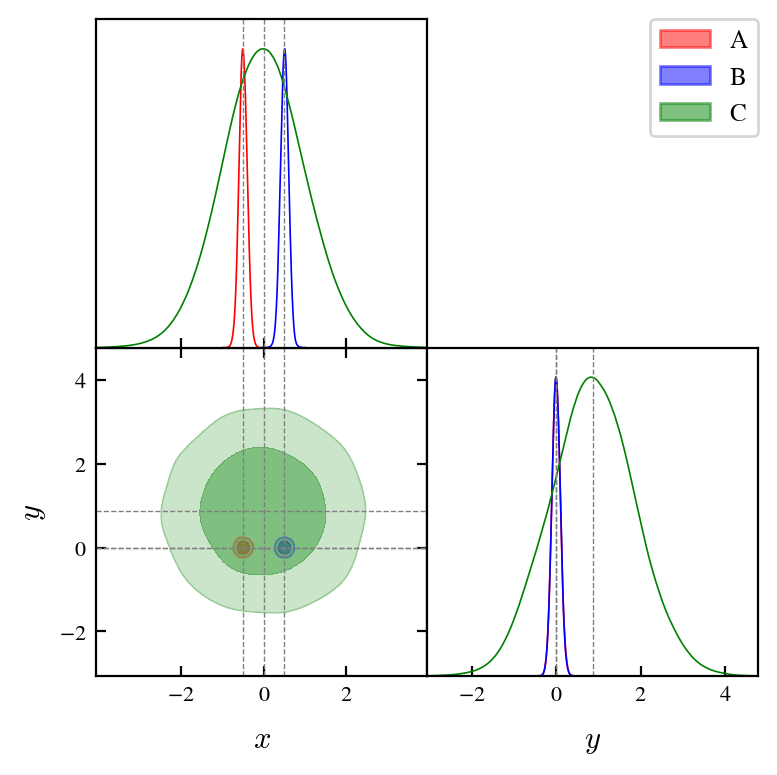

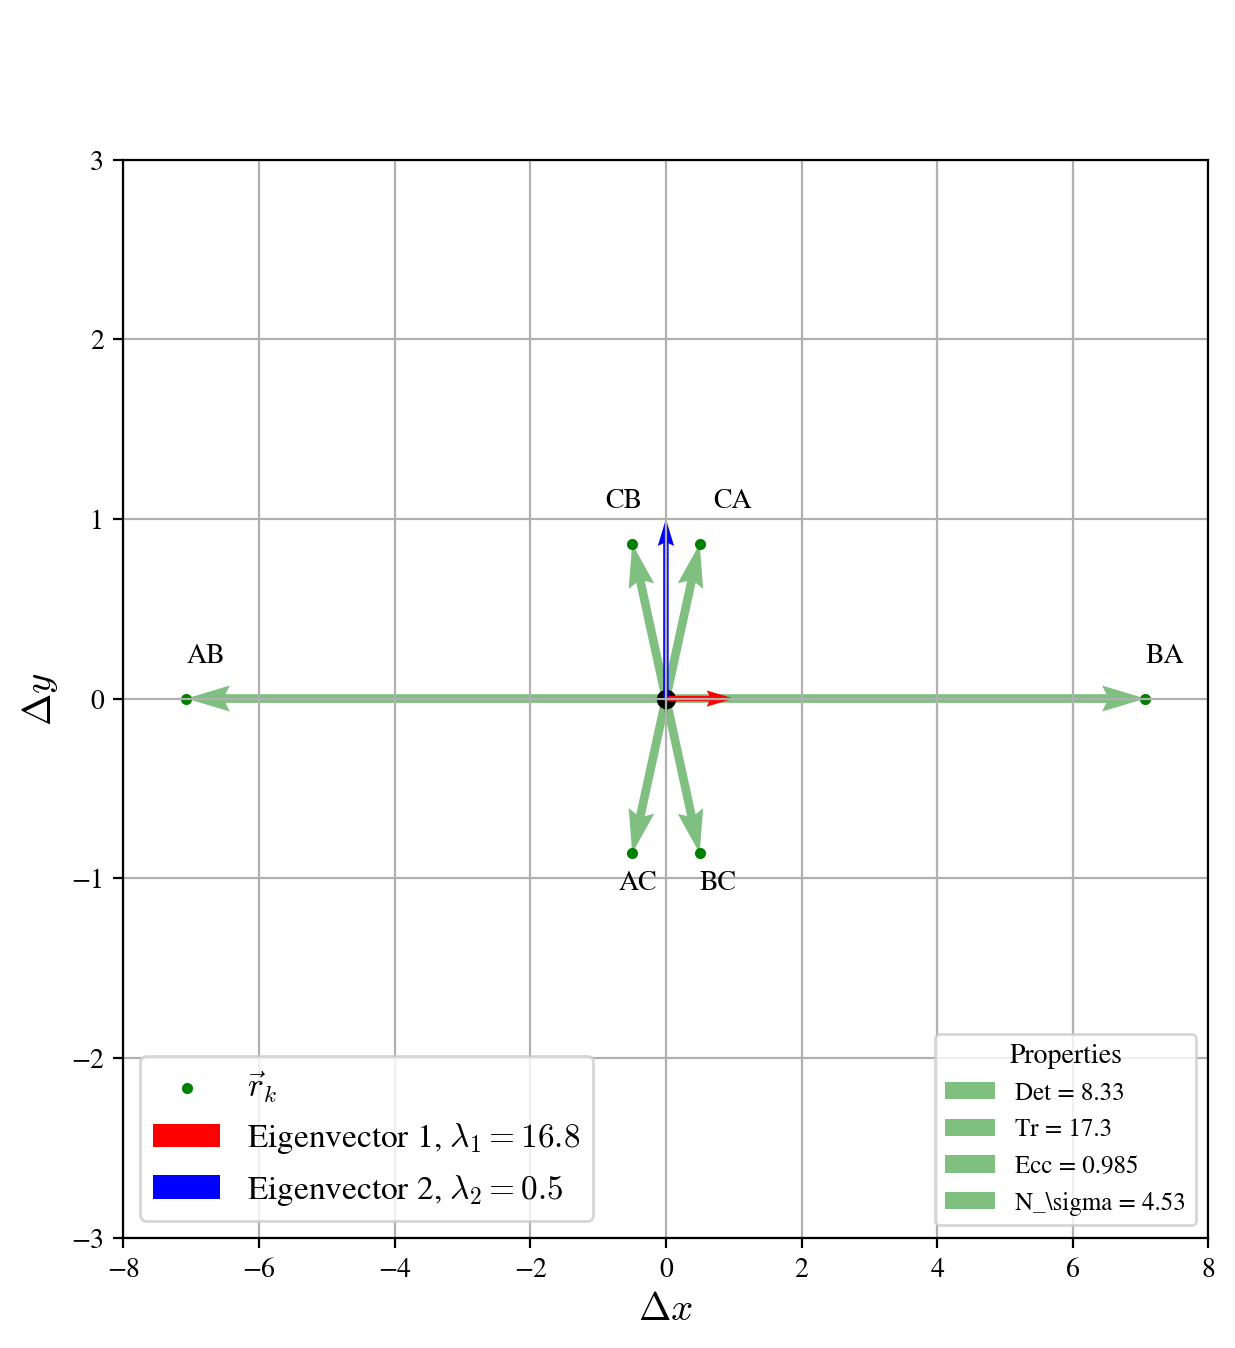

6e-06
Effective model parameter l: 3.97
Effective model parameter N_sigma_eff: 2.34


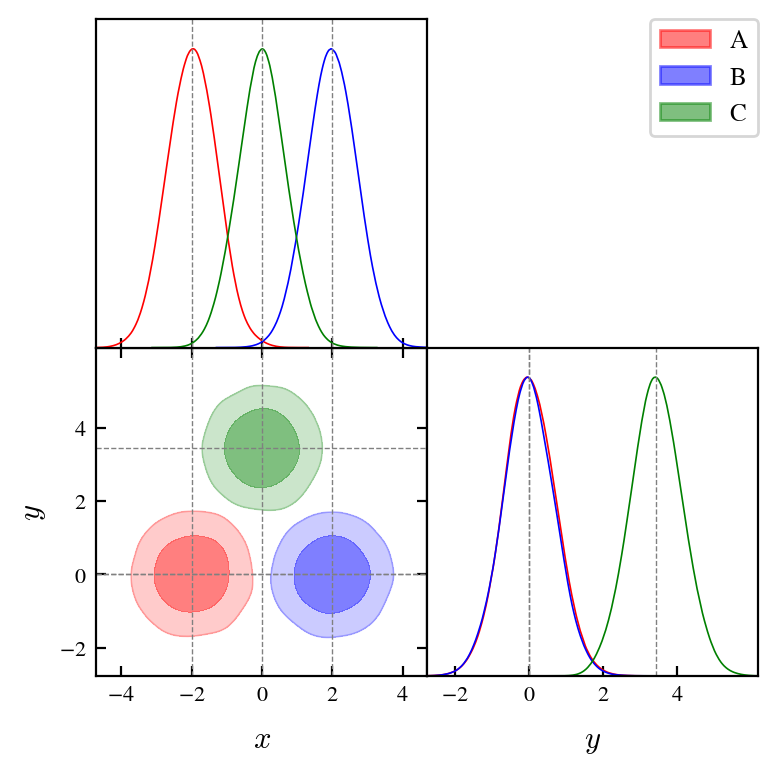

In [81]:
mean_A = np.array([-1/2., 0.]) 
mean_B = np.array([1/2, 0.])
mean_C = np.array([0, np.sqrt(3)/2.])

cov_A = np.array([[0.01, 0.], [0., 0.01]])
cov_B = cov_A.copy()
cov_C = 100*cov_A.copy()

r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))
r_4 = - r_1
r_5 = - r_2
r_6 = - r_3

title='Case 4' 
title=' ' 
name_plot='4'
analytic_tension=False 
eff_dist=True
png=False


names = ['x', 'y']
labels = ['x', 'y']

r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))
r_4 = - r_1
r_5 = - r_2
r_6 = - r_3

# Example usage:
C_tot = construct_C(np.array([r_1, r_2, r_3, r_4, r_5, r_6]))

beta_L = (np.linalg.norm(r_1)**2 + np.linalg.norm(r_2)**2 + np.linalg.norm(r_3)**2)/3
if analytic_tension == False:
    Q_H0 =Q_tot_quad(mean_A, mean_B, mean_C, cov_A, cov_B, cov_C, n_samples, 3, H0=True)
    PTE = Q_H0[Q_H0 > beta_L].size/Q_H0.size
    
elif analytic_tension == True:
    PTE = gamma(d,1).sf(beta_L)

n_sigma = np.sqrt(2)*erfcinv(PTE)


lim_x = np.array([-8, 8])
lim_y = np.array([-3, 3])

samps_A = np.random.multivariate_normal(mean_A, cov_A, size=10000)
samps_B = np.random.multivariate_normal(mean_B, cov_B, size=10000)
samps_C = np.random.multivariate_normal(mean_C, cov_C, size=10000)

chain_A = MCSamples(samples=samps_A, names=names, labels=labels, label='Dataset A')
chain_B = MCSamples(samples=samps_B, names=names, labels=labels, label='Dataset B')
chain_C = MCSamples(samples=samps_C, names=names, labels=labels, label='Dataset C')

colors = ['red', 'blue', 'green']

g = plots.get_subplot_plotter()
g.triangle_plot([chain_A, chain_B, chain_C],\
                filled=True, contour_args={'alpha':0.5},\
                contour_colors=colors,
                legend_labels=['A', 'B', 'C'])

g.add_param_markers({'x':[mean_A[0], mean_B[0], mean_C[0]],
                        'y':[mean_A[1], mean_B[1], mean_C[1]],
                    },)

if png==True:
    g.export('dist_{}.png'.format(name_plot))
else:
    g.export('dist_{}.pdf'.format(name_plot))
    g.export('dist_eff_{}.svg'.format(name_plot))

#fig, ax = plt.subplots(1,1, figsize=(14,10))
fig, ax = plt.subplots(1,1, figsize=(7,7))
fig.suptitle(title, fontsize=16)


ax.set_xlabel(r'$\Delta x$',size=14)
ax.set_ylabel(r'$\Delta y$',size=14)
#ax.hlines(0, lim_x[0], lim_x[1], color='black', lw=0.5)
#ax.vlines(0, lim_y[0], lim_y[1], color='black', lw=0.5)

ax.quiver(0, 0, r_1[0], r_1[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.008,alpha=0.5)
ax.quiver(0, 0, r_2[0], r_2[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.008,alpha=0.5)
ax.quiver(0, 0, r_3[0], r_3[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.008,alpha=0.5)
ax.quiver(0, 0, r_4[0], r_4[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.008,alpha=0.5)
ax.quiver(0, 0, r_5[0], r_5[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.008,alpha=0.5)
ax.quiver(0, 0, r_6[0], r_6[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.008,alpha=0.5)

ax.scatter([r_1[0], r_2[0], r_3[0], r_4[0], r_5[0], r_6[0]], [r_1[1], r_2[1], r_3[1], r_4[1], r_5[1], r_6[1]], marker='.',color='green', label=r'$\vec{r}_{k}$')
ax.scatter([0], [0], color='black')#, label='CM')

ax.quiver(0, 0, np.linalg.eig(C_tot)[1][0, 0], np.linalg.eig(C_tot)[1][1, 0], angles='xy', scale_units='xy', scale=1, color='r', width=0.005,label=r'Eigenvector 1, $\lambda_1={:.1f}$'.format(np.linalg.eig(C_tot)[0][0]))
ax.quiver(0, 0, np.linalg.eig(C_tot)[1][0, 1], np.linalg.eig(C_tot)[1][1, 1], angles='xy', scale_units='xy', scale=1, color='b', width=0.005,label=r'Eigenvector 2, $\lambda_2={:.1f}$'.format(np.linalg.eig(C_tot)[0][1]))

# Adjust text positions to avoid overlap
offsets = [(0.0, 0.2), (-0.2, -0.2), (0.0, -0.2), (0.0, 0.2), (0.2, 0.2), (-0.4, 0.2)]
texts = ['AB', 'AC', 'BC', 'BA', 'CA', 'CB']
points = [r_1, r_2, r_3, r_4, r_5, r_6]

for i, (point, text, offset) in enumerate(zip(points, texts, offsets)):
    ax.text(point[0] + offset[0], point[1] + offset[1], text, size=10)

'''
ax.text(r_1[0]-0.5, r_1[1]+0.5, 'AB', size=10)
ax.text(r_2[0]-0.5, r_2[1]-0.5, 'AC', size=10)
ax.text(r_3[0]-0.0, r_3[1]-0.5, 'BC', size=10)
ax.text(r_4[0]-0.5, r_4[1]+0.5, 'BA', size=10)
ax.text(r_5[0]-0.5, r_5[1]-0.5, 'CA', size=10)
ax.text(r_6[0]-0.0, r_6[1]-0.5, 'CB', size=10)
'''

ax.set_xlim(*lim_x)
ax.set_ylim(*lim_y)

ax.legend()
ax.grid()

# Para mostrar ambas leyendas en la parte inferior, puedes usar handles y labels manualmente:
handles1, labels1 = ax.get_legend_handles_labels()
legend1 = ax.legend(handles=handles1, labels=labels1, loc='lower left', fontsize=12)
ax.add_artist(legend1)

legend2 = ax.legend(
    [f'Det = {np.prod(np.linalg.eigvals(C_tot)):.3g}', 
    f'Tr = {np.sum(np.linalg.eigvals(C_tot)):.3g}',
    f'Ecc = {np.sqrt(1-np.min(np.linalg.eigvals(C_tot)) / np.max(np.linalg.eigvals(C_tot))):.3g}',
    f'N_\sigma = {n_sigma:.3g}'],
    loc='lower right', fontsize=9, title='Properties'
)


#os.chdir(os.path.join(path_git, 'notebooks','PRL', 'tests', 'figures'))
if png==True:
    fig.savefig(os.path.join(path_global, 'geom_{}_beta.png'.format(name_plot)), dpi=300, bbox_inches='tight')
else:
    fig.savefig(os.path.join(path_global, 'geom_{}_beta.pdf'.format(name_plot)), dpi=300, bbox_inches='tight')
    fig.savefig(os.path.join(path_global, 'geom_{}_beta.svg'.format(name_plot)), dpi=300, bbox_inches='tight')
plt.show()

if eff_dist == True:
    print(PTE)
    plot_eff_model(PTE, name_plot=name_plot, png=True)

# Real Data

In [ ]:
import git
import sys, os

'''
A: CC 
B: Planck18 
C: BAO 
D: PPS
'''

'''
os.chdir(os.path.join(path_global,'montepython_public_old','output'))   

chain_A = getdist.mcsamples.loadMCSamples(file_root='lcdm_cc/2023-09-18_1000000_', no_cache=True,settings={'loglikes':True,'label':'CC','ignore_rows': '0.3'})
chain_B = getdist.mcsamples .loadMCSamples(file_root='lcdm_planck/2023-09-16_1000000_', no_cache=True,settings={'loglikes':True,'label':'Planck18','ignore_rows': '0.3'})
chain_C = getdist.mcsamples.loadMCSamples(file_root='lcdm_bao_plus/2024-03-07_1000000_', no_cache=True,settings={'label':'BAO','ignore_rows': '0.3'})
chain_D = getdist.mcsamples.loadMCSamples(file_root='lcdm_pps/2023-09-18_1000000_', no_cache=True,settings={'label':'PPS','ignore_rows': '0.3'})
'''




os.chdir(os.path.join(path_global,'Cobaya','output','cluster','lcdm'))

chain_A = getdist.mcsamples.loadMCSamples(file_root='lcdm_cc/lcdm_cc', no_cache=True,settings={'loglikes':True,'names':'CC','label':'CC','ignore_rows': '0.3'})
chain_B = getdist.mcsamples.loadMCSamples(file_root='lcdm_planck/lcdm_planck', no_cache=True,settings={'loglikes':True,'names':'Planck18','label':'Planck18','ignore_rows': '0.3'})
chain_C = getdist.mcsamples.loadMCSamples(file_root='lcdm_desi_dr2/lcdm_desi_dr2', no_cache=True,settings={'loglikes':True,'names':'DESI DR2','label':'DESI DR2','ignore_rows': '0.3'})
chain_D = getdist.mcsamples.loadMCSamples(file_root='lcdm_pps/lcdm_pps', no_cache=True,settings={'names':'PPS','label':'PPS','ignore_rows': '0.3'})



param_names = ['Omega_m','H0'] #Shared paameters
names = param_names
labels = ['\Omega_m','H_0']

#Estimate the mean and covariance of the chains:
mean_A_0 = chain_A.mean(param_names)
mean_B_0 = chain_B.mean(param_names)
mean_C_0 = chain_C.mean(param_names)
mean_D_0 = chain_D.mean(param_names)

cov_A_0 = chain_A.cov(param_names)
cov_B_0 = chain_B.cov(param_names)
cov_C_0 = chain_C.cov(param_names)
cov_D_0 = chain_D.cov(param_names)

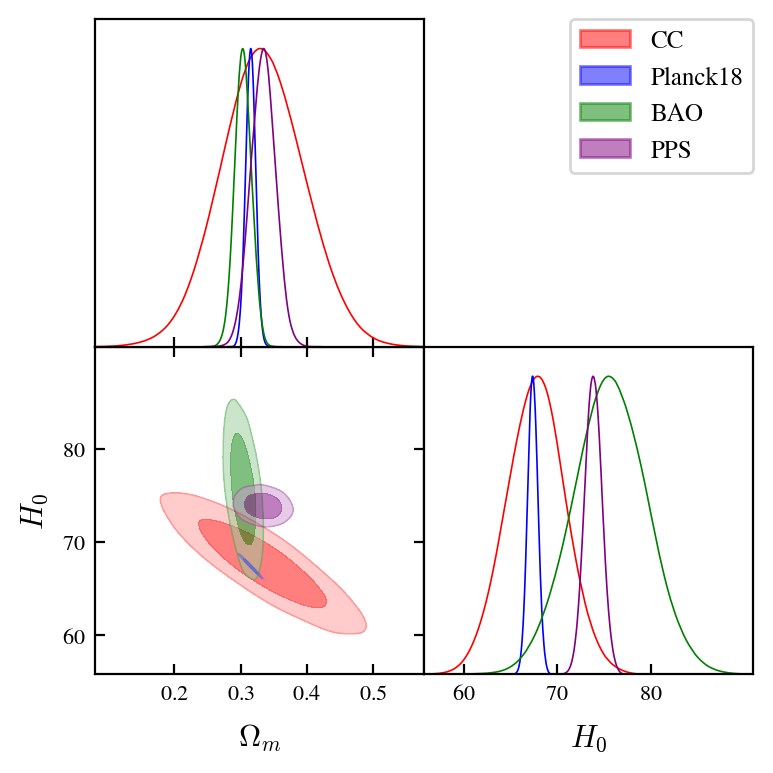

In [83]:
samps_A = np.random.multivariate_normal(mean_A_0, cov_A_0, size=10000)
samps_B = np.random.multivariate_normal(mean_B_0, cov_B_0, size=10000)
samps_C = np.random.multivariate_normal(mean_C_0, cov_C_0, size=10000)
samps_D = np.random.multivariate_normal(mean_D_0, cov_D_0, size=10000)

chain_A = MCSamples(samples=samps_A, names=names, labels=labels, label='Dataset A')
chain_B = MCSamples(samples=samps_B, names=names, labels=labels, label='Dataset B')
chain_C = MCSamples(samples=samps_C, names=names, labels=labels, label='Dataset C')
chain_D = MCSamples(samples=samps_D, names=names, labels=labels, label='Dataset D')

colors = ['red', 'blue', 'green', 'purple']

g = plots.get_subplot_plotter()
g.triangle_plot([chain_A, chain_B, chain_C, chain_D],\
                filled=True, contour_args={'alpha':0.5},\
                contour_colors=colors,
                legend_labels=['CC', 'Planck18', 'BAO', 'PPS'],
                labels=[r'$\Omega_m$', r'$H_0$'])

g.export(os.path.join(path_global, 'dist_data_tot.pdf'))
g.export(os.path.join(path_global, 'dist_data_tot.svg'))
plt.show()

## Without CC

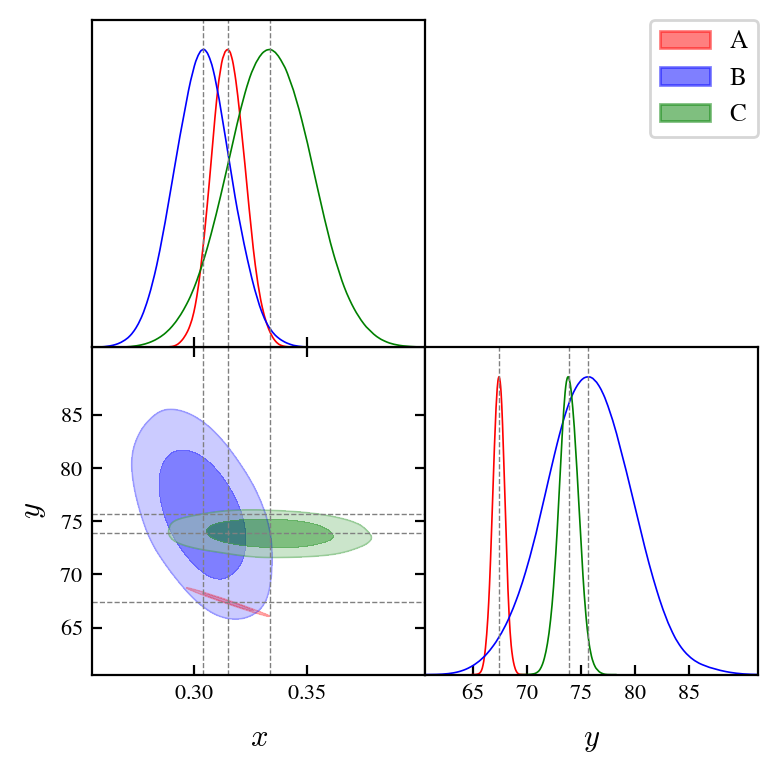

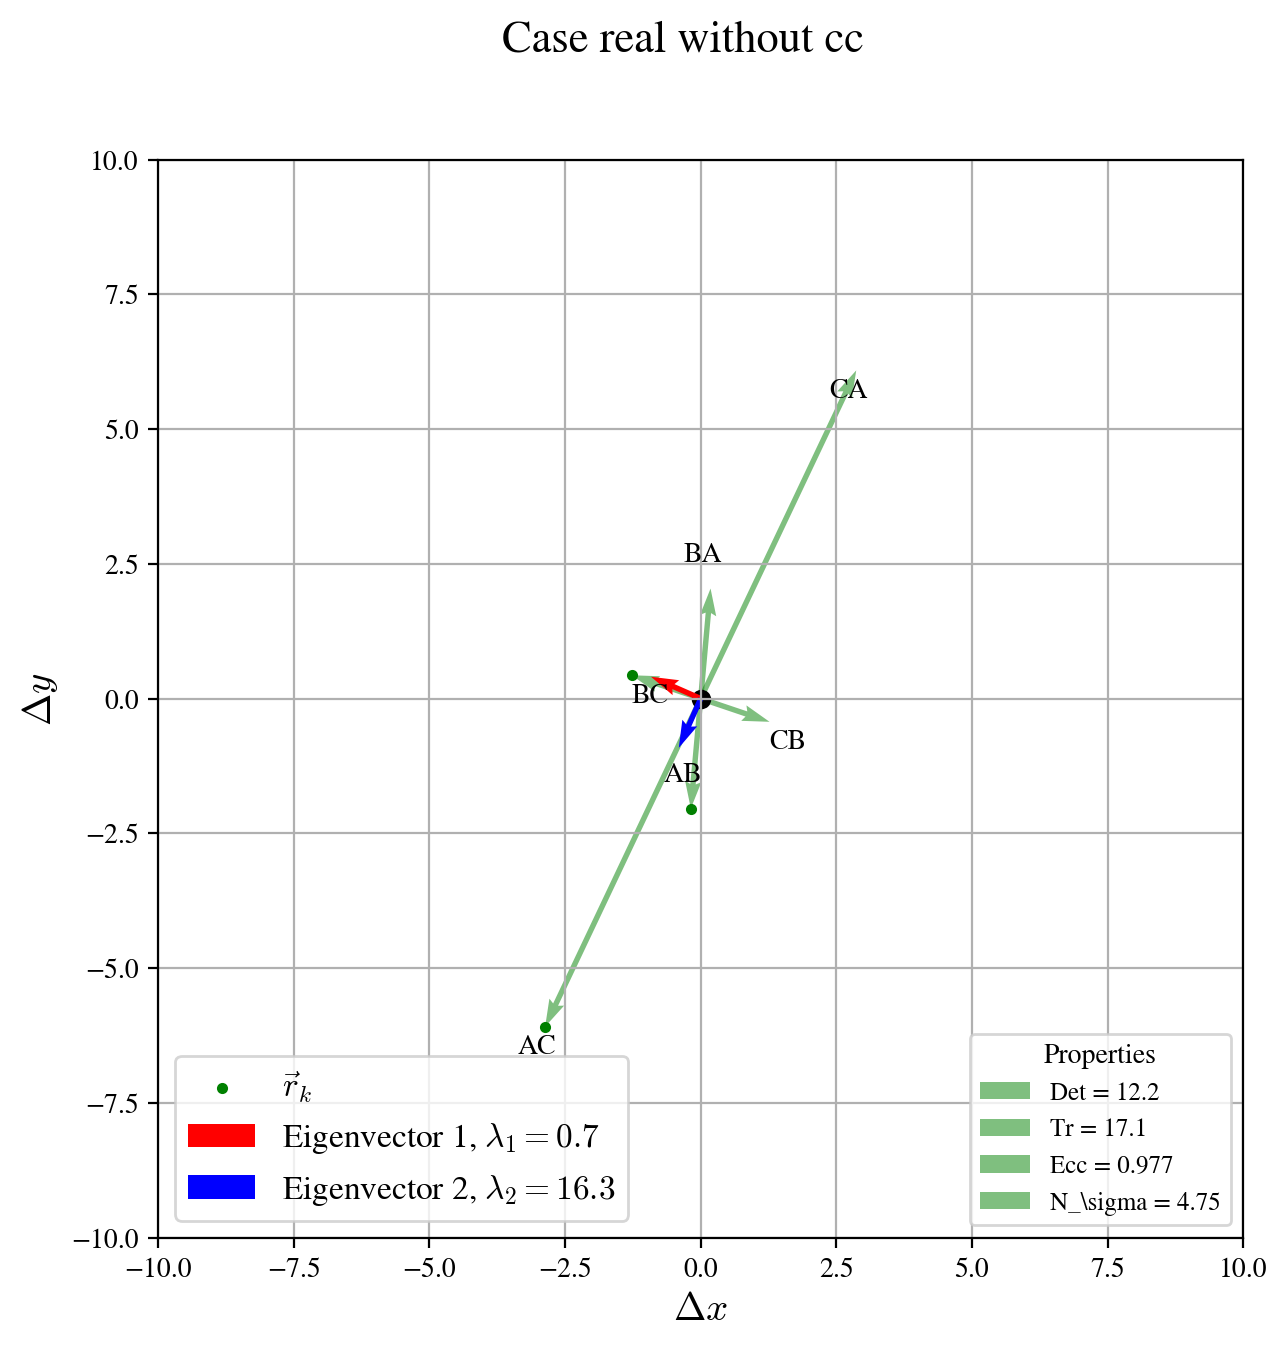

2e-06
Effective model parameter l: 4.12
Effective model parameter N_sigma_eff: 2.45


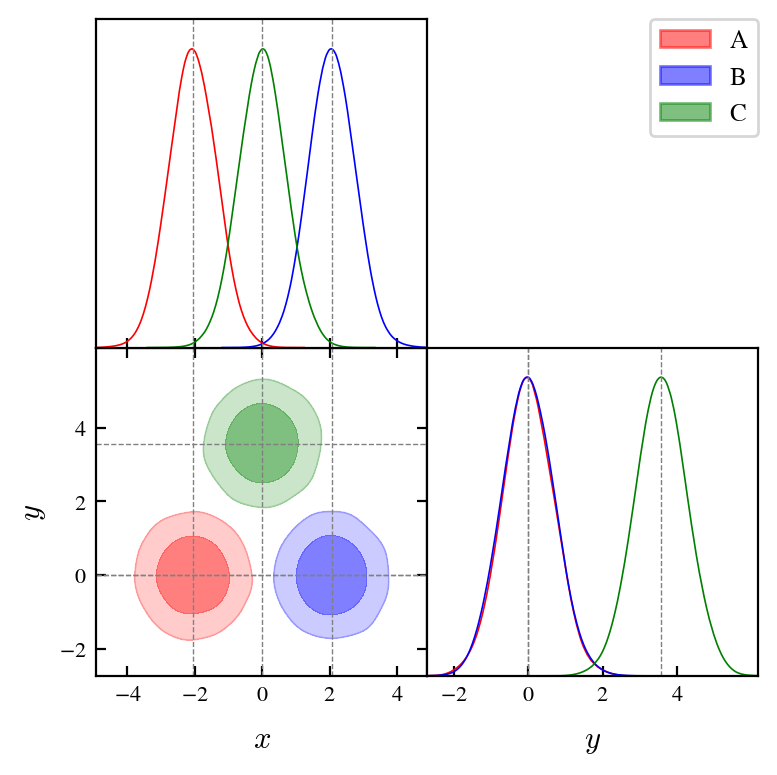

Mean eigenvalue: 2.85, Standard deviation: 7.8


In [84]:
mean_A = mean_B_0
mean_B = mean_C_0
mean_C = mean_D_0

cov_A = cov_B_0
cov_B = cov_C_0
cov_C = cov_D_0


r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))
r_4 = - r_1
r_5 = - r_2
r_6 = - r_3

plot_geom(mean_A, mean_B, mean_C, cov_A, cov_B, cov_C, title='Case real without cc', name_plot='wthout_cc',
          analytic_tension=False, eff_dist=True)

vectors = np.array([r_1, r_2, r_3, r_4, r_5, r_6])
C = construct_C(vectors)
eigenval_min = np.min(np.linalg.eigvals(C))
eigenval_max = np.max(np.linalg.eigvals(C))

if np.linalg.det(C) == 0:
    print('Determinant is zero.. for a deeper analysis reduce the dimension')

elif np.abs(eigenval_min - eigenval_max) < 1e-3:
    print(f'All eigenvalues are equal: {eigenval_min :.3g} and {eigenval_max :.3g}')
else:
    mean_lambda, std_lambda = analyzed_lambdas(vectors)
    print(f'Mean eigenvalue: {mean_lambda :.3g}, Standard deviation: {std_lambda :.3g}')

    k = mean_lambda**2 / std_lambda**2
    theta = std_lambda**2 / mean_lambda
    dist_1 = st.gamma(a=k, scale=theta, loc=0).rvs(1000)

    sigma_ln = np.sqrt(np.log(1 + std_lambda**2 / mean_lambda**2))
    mu_ln = np.log(mean_lambda) - 0.5*sigma_ln**2
    dist_2 = st.lognorm(s=sigma_ln, scale=np.exp(mu_ln)).rvs(1000)

    dist_3 = st.norm(loc=mean_lambda, scale=std_lambda).rvs(1000)

## Without Planck

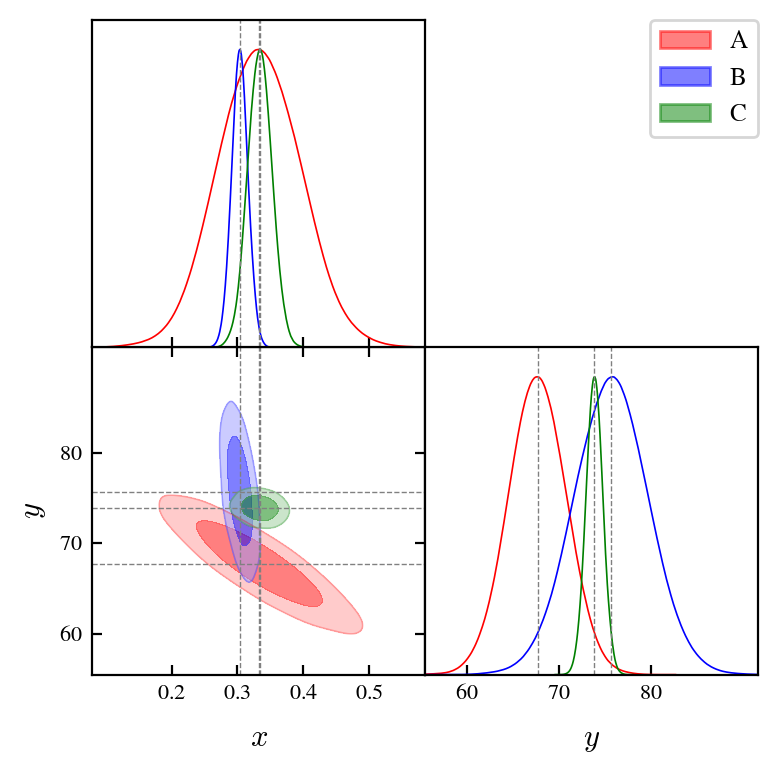

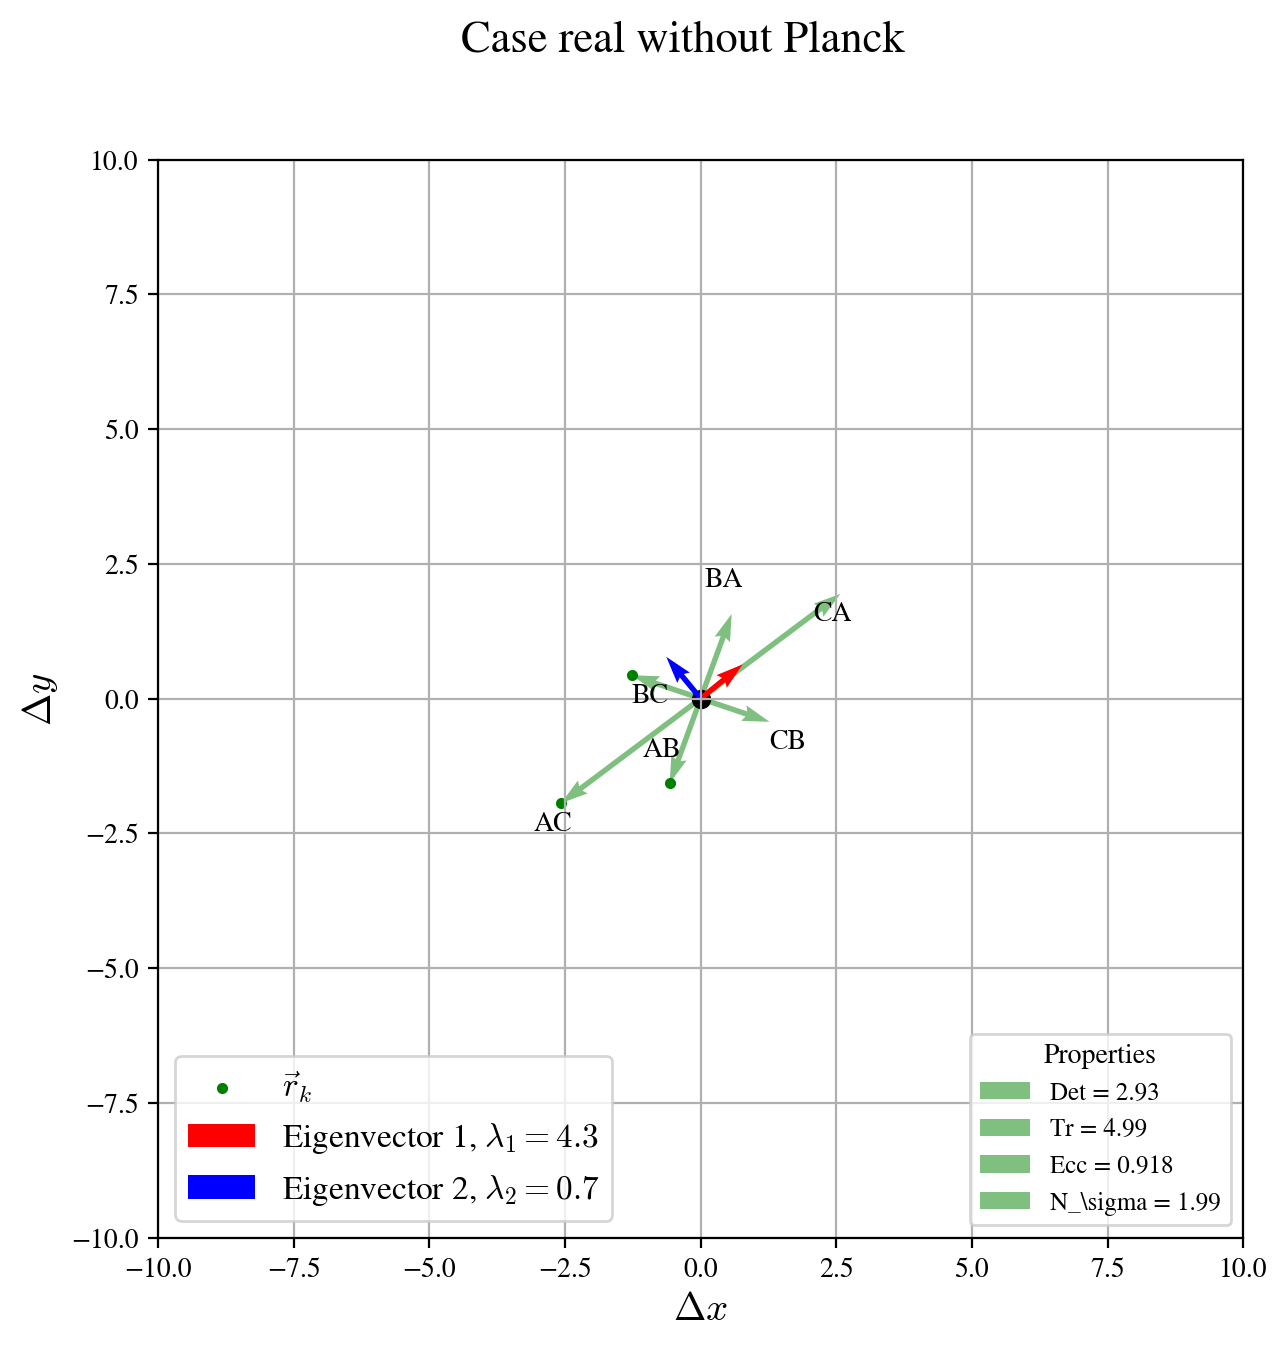

0.046472
Effective model parameter l: 2.42
Effective model parameter N_sigma_eff: 1.19


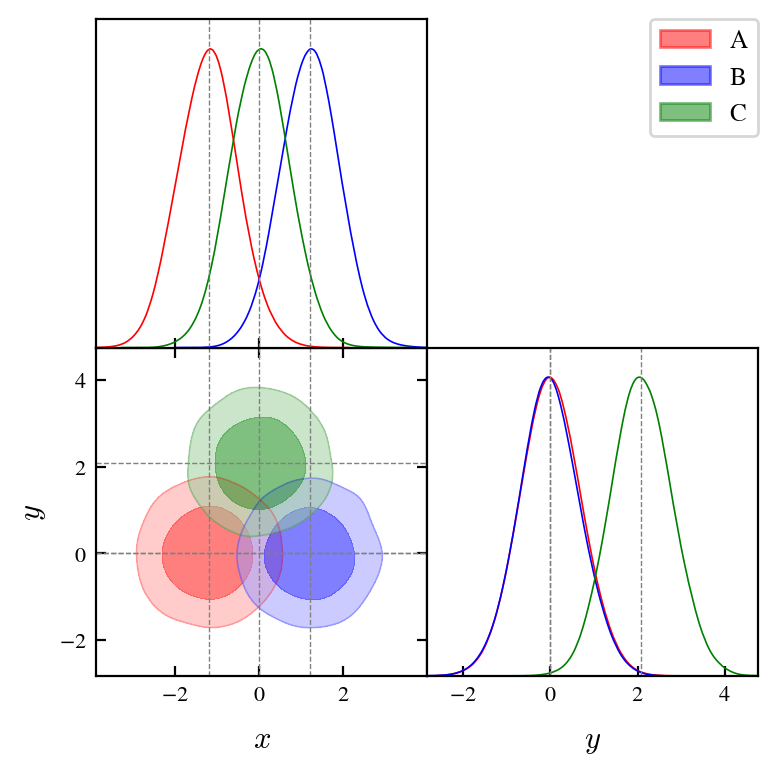

Mean eigenvalue: 0.832, Standard deviation: 1.82


In [85]:
mean_A = mean_A_0
mean_B = mean_C_0
mean_C = mean_D_0

cov_A = cov_A_0
cov_B = cov_C_0
cov_C = cov_D_0


r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))
r_4 = - r_1
r_5 = - r_2
r_6 = - r_3

plot_geom(mean_A, mean_B, mean_C, cov_A, cov_B, cov_C, title='Case real without Planck', name_plot='wthout_Planck',
          analytic_tension=False, eff_dist=True)

vectors = np.array([r_1, r_2, r_3, r_4, r_5, r_6])
C = construct_C(vectors)
eigenval_min = np.min(np.linalg.eigvals(C))
eigenval_max = np.max(np.linalg.eigvals(C))

if np.linalg.det(C) == 0:
    print('Determinant is zero.. for a deeper analysis reduce the dimension')

elif np.abs(eigenval_min - eigenval_max) < 1e-3:
    print(f'All eigenvalues are equal: {eigenval_min :.3g} and {eigenval_max :.3g}')
else:
    mean_lambda, std_lambda = analyzed_lambdas(vectors)
    print(f'Mean eigenvalue: {mean_lambda :.3g}, Standard deviation: {std_lambda :.3g}')

    k = mean_lambda**2 / std_lambda**2
    theta = std_lambda**2 / mean_lambda
    dist_1 = st.gamma(a=k, scale=theta, loc=0).rvs(1000)

    sigma_ln = np.sqrt(np.log(1 + std_lambda**2 / mean_lambda**2))
    mu_ln = np.log(mean_lambda) - 0.5*sigma_ln**2
    dist_2 = st.lognorm(s=sigma_ln, scale=np.exp(mu_ln)).rvs(1000)

    dist_3 = st.norm(loc=mean_lambda, scale=std_lambda).rvs(1000)

## Without BAO

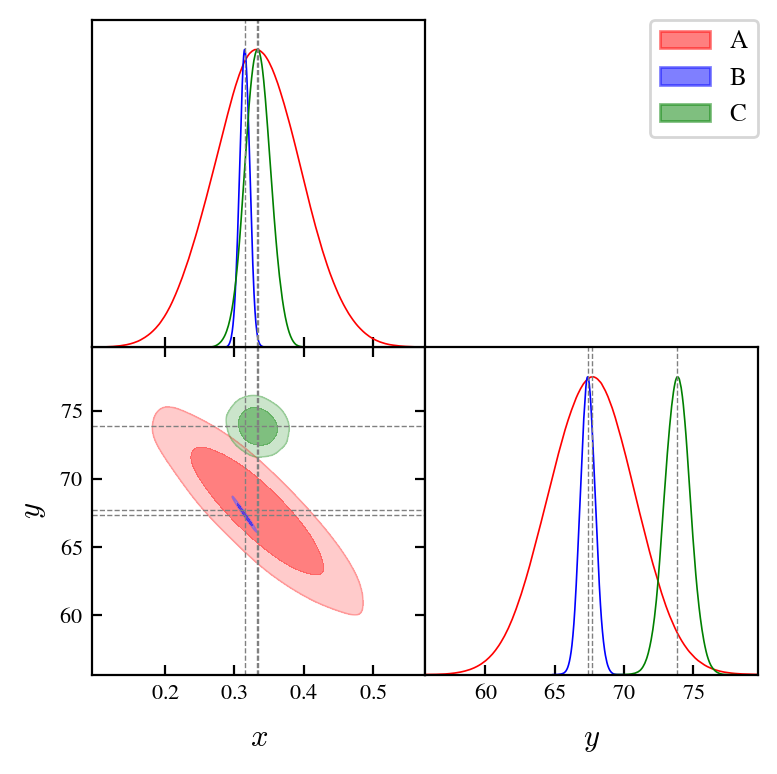

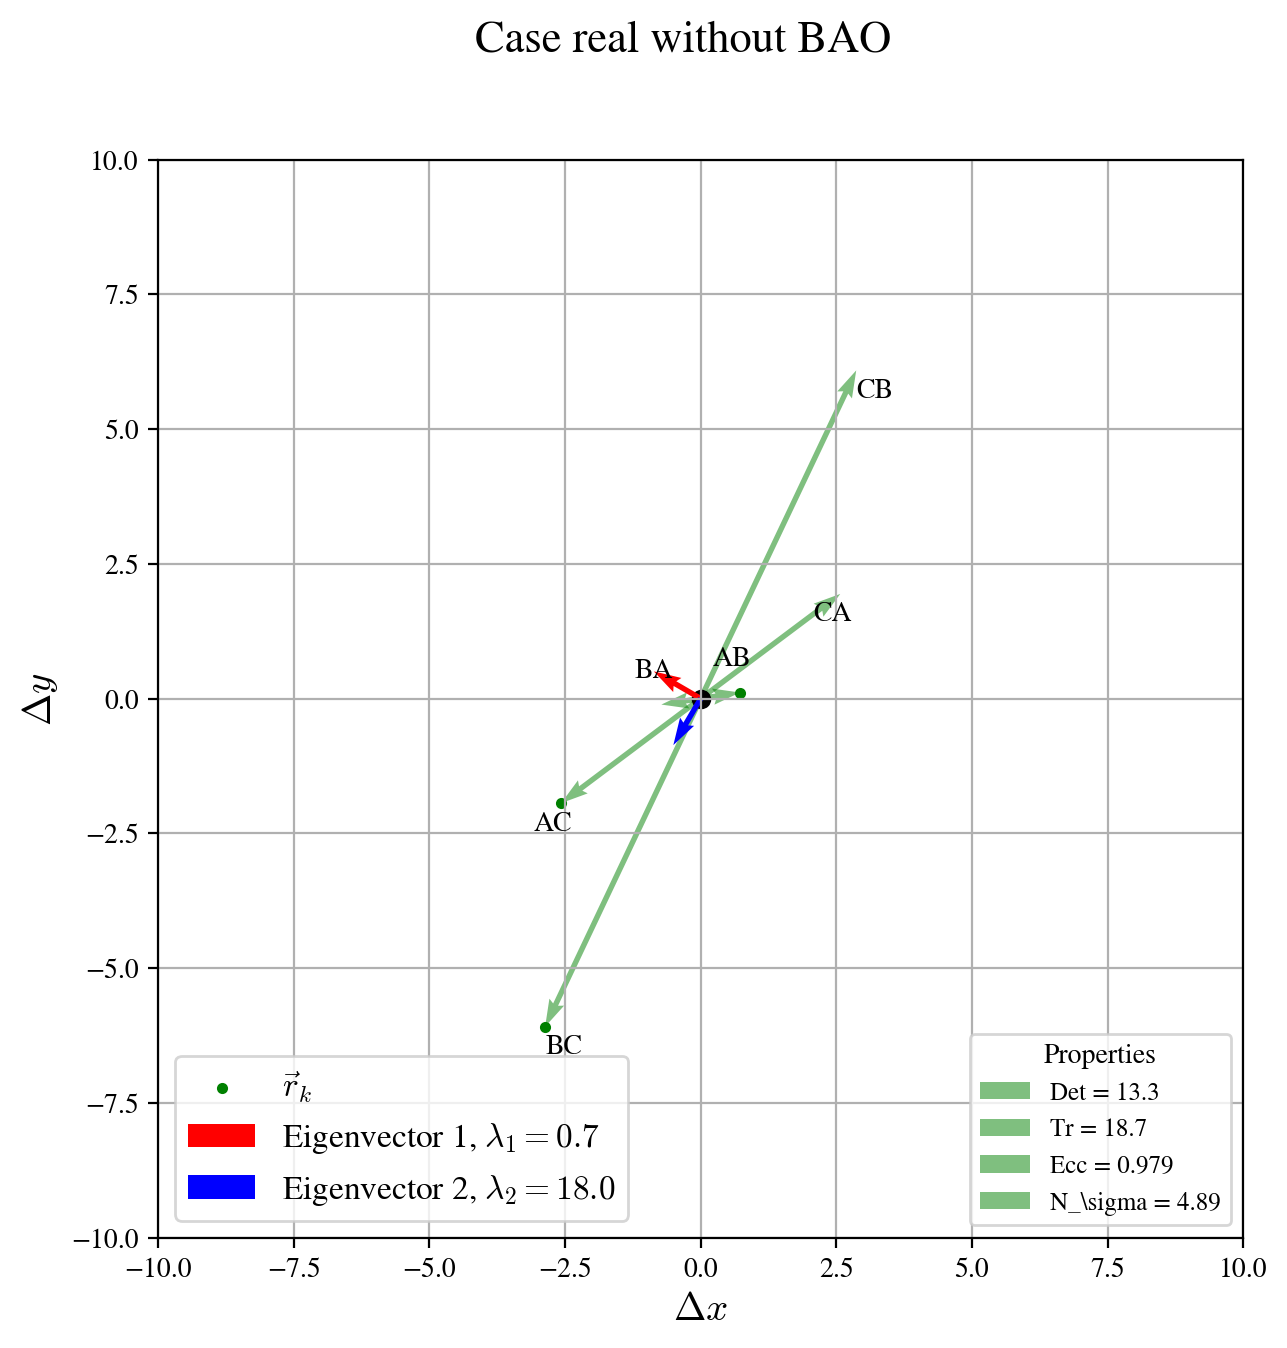

1e-06
Effective model parameter l: 4.21
Effective model parameter N_sigma_eff: 2.51


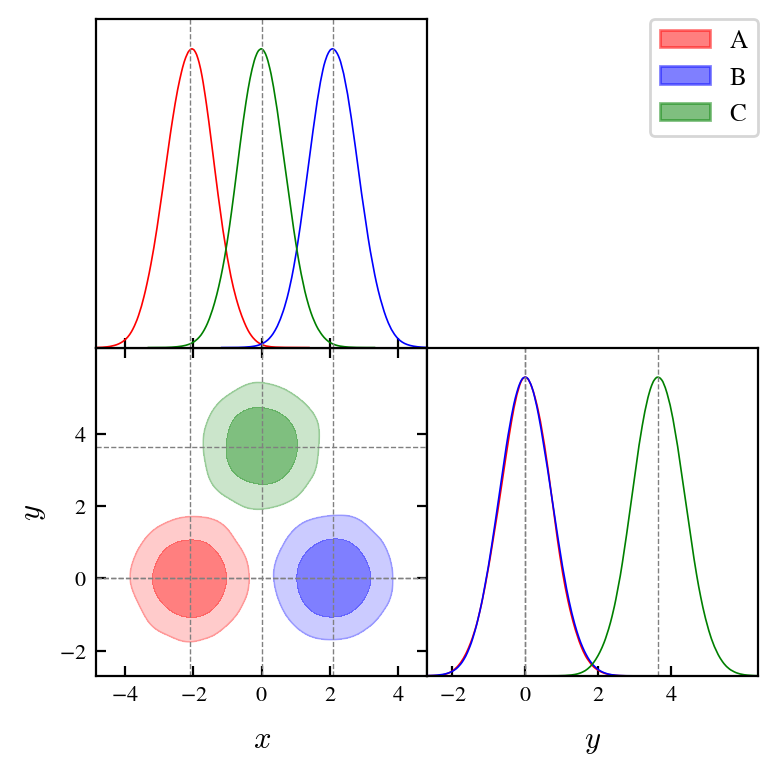

Mean eigenvalue: 3.12, Standard deviation: 8.63


In [86]:
mean_A = mean_A_0
mean_B = mean_B_0
mean_C = mean_D_0

cov_A = cov_A_0
cov_B = cov_B_0
cov_C = cov_D_0


r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))
r_4 = - r_1
r_5 = - r_2
r_6 = - r_3

plot_geom(mean_A, mean_B, mean_C, cov_A, cov_B, cov_C, title='Case real without BAO', name_plot='  ',
          analytic_tension=False, eff_dist=True)

vectors = np.array([r_1, r_2, r_3, r_4, r_5, r_6])
C = construct_C(vectors)
eigenval_min = np.min(np.linalg.eigvals(C))
eigenval_max = np.max(np.linalg.eigvals(C))

if np.linalg.det(C) == 0:
    print('Determinant is zero.. for a deeper analysis reduce the dimension')

elif np.abs(eigenval_min - eigenval_max) < 1e-3:
    print(f'All eigenvalues are equal: {eigenval_min :.3g} and {eigenval_max :.3g}')
else:
    mean_lambda, std_lambda = analyzed_lambdas(vectors)
    print(f'Mean eigenvalue: {mean_lambda :.3g}, Standard deviation: {std_lambda :.3g}')

    k = mean_lambda**2 / std_lambda**2
    theta = std_lambda**2 / mean_lambda
    dist_1 = st.gamma(a=k, scale=theta, loc=0).rvs(1000)

    sigma_ln = np.sqrt(np.log(1 + std_lambda**2 / mean_lambda**2))
    mu_ln = np.log(mean_lambda) - 0.5*sigma_ln**2
    dist_2 = st.lognorm(s=sigma_ln, scale=np.exp(mu_ln)).rvs(1000)

    dist_3 = st.norm(loc=mean_lambda, scale=std_lambda).rvs(1000)

## Without PPS

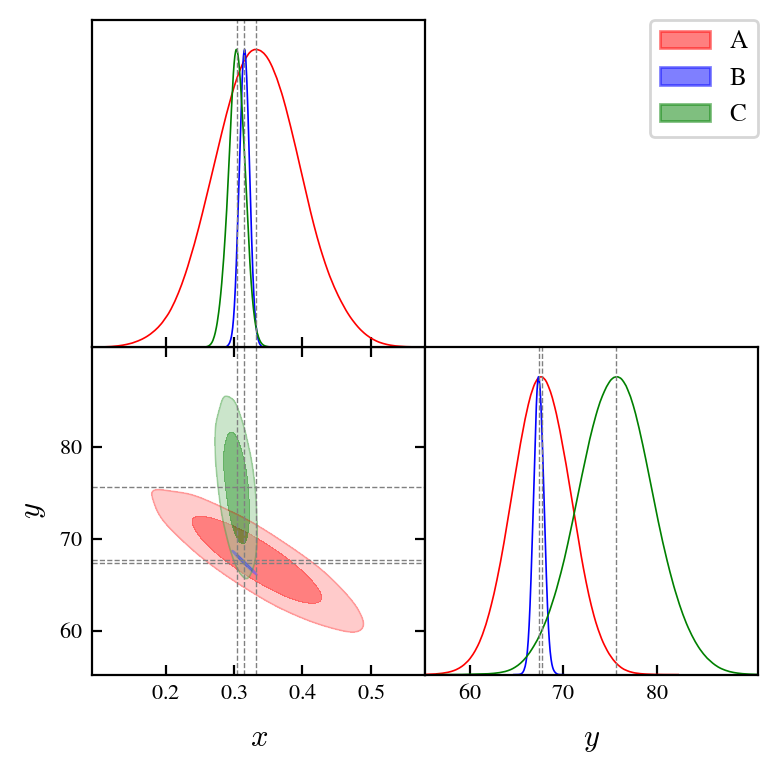

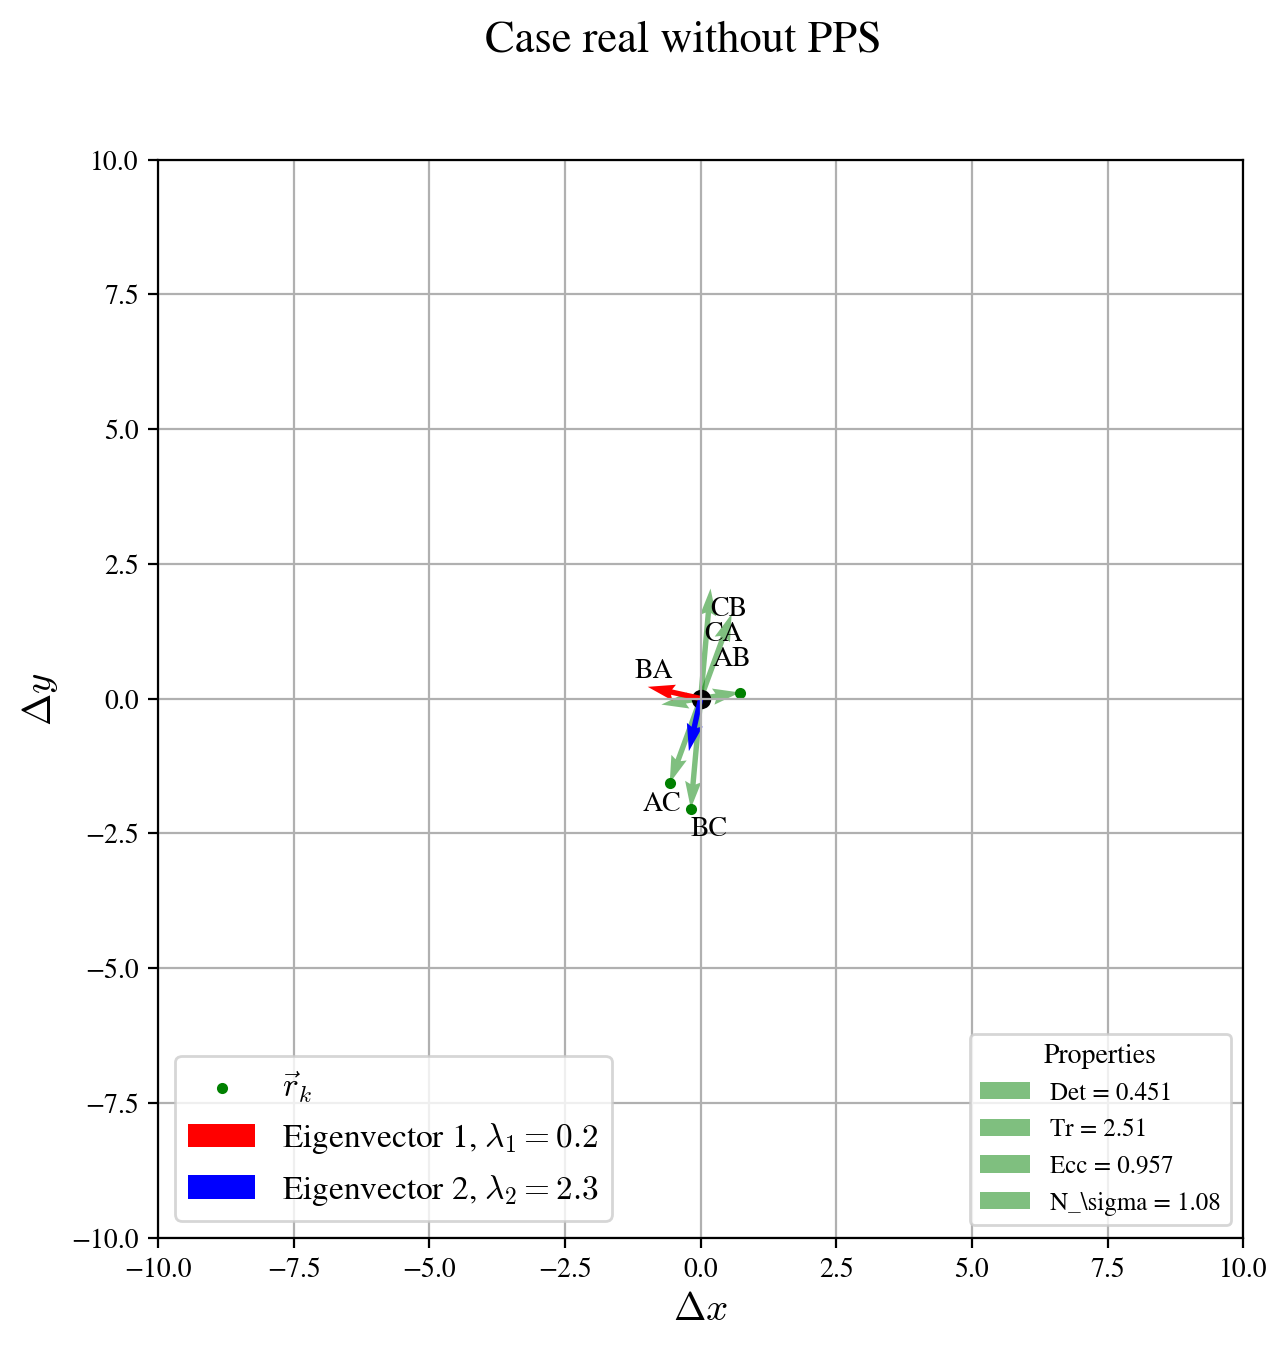

0.28123
Effective model parameter l: 1.88
Effective model parameter N_sigma_eff: 0.817


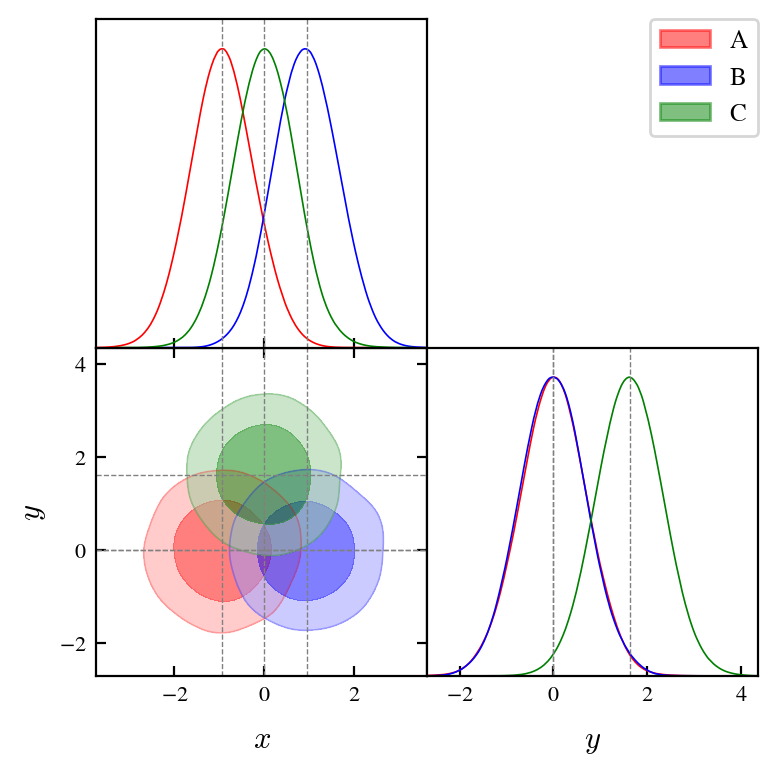

Mean eigenvalue: 0.418, Standard deviation: 1.06


In [87]:
mean_A = mean_A_0
mean_B = mean_B_0
mean_C = mean_C_0

cov_A = cov_A_0
cov_B = cov_B_0
cov_C = cov_C_0


r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))
r_4 = - r_1
r_5 = - r_2
r_6 = - r_3

plot_geom(mean_A, mean_B, mean_C, cov_A, cov_B, cov_C, title='Case real without PPS', name_plot='wthout_PPS',
          analytic_tension=False, eff_dist=True)

vectors = np.array([r_1, r_2, r_3, r_4, r_5, r_6])
C = construct_C(vectors)
eigenval_min = np.min(np.linalg.eigvals(C))
eigenval_max = np.max(np.linalg.eigvals(C))

if np.linalg.det(C) == 0:
    print('Determinant is zero.. for a deeper analysis reduce the dimension')

elif np.abs(eigenval_min - eigenval_max) < 1e-3:
    print(f'All eigenvalues are equal: {eigenval_min :.3g} and {eigenval_max :.3g}')
else:
    mean_lambda, std_lambda = analyzed_lambdas(vectors)
    print(f'Mean eigenvalue: {mean_lambda :.3g}, Standard deviation: {std_lambda :.3g}')

    k = mean_lambda**2 / std_lambda**2
    theta = std_lambda**2 / mean_lambda
    dist_1 = st.gamma(a=k, scale=theta, loc=0).rvs(1000)

    sigma_ln = np.sqrt(np.log(1 + std_lambda**2 / mean_lambda**2))
    mu_ln = np.log(mean_lambda) - 0.5*sigma_ln**2
    dist_2 = st.lognorm(s=sigma_ln, scale=np.exp(mu_ln)).rvs(1000)

    dist_3 = st.norm(loc=mean_lambda, scale=std_lambda).rvs(1000)